<a href="https://colab.research.google.com/github/malloyca/steelpan-pitch/blob/main/onset-pitch/steelpan_onset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Steelpan Onset-based Pitch Detection

For 183rd Meeting of the Acoustical Society of America, December 8, 2022.

## Todo

- Set up associated .csv file to store the performance based on `frame_length` and `hop_size` using pandas
- Create chart of estimation data
- Create a histogram of error amounts for each method (rounded to nearest MIDI integer / pitch class)
  - This will give us insight into the kind of errors each method is making

In [1]:
!pip install crepe
import crepe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.4/323.4 KB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.1/217.1 KB 23.5 MB/s eta 0:00:00
  Created wheel for crepe: filename=crepe-0.0.13-py3-none-any.whl size=134848712 sha256=d48e876687cede09e7380e914f0cb286088220fba61ca7d1a114cdc7c181dd08
  Stored in directory: /root/.cache/pip/wheels/d8/68/be/b163712f8f71a6939dbaf4c26bbda6612a1e609b795af7a15e
  Created wheel for resampy: filename=resampy-0.2.2-py3-none-any.whl size=320730 sha256=350f43181b68b3c8ab136d25ee336ad9026d4e325a7f41d3b61cfa688b1c335b
  Stored in directory: /root/.cache/pip/wheels/6f/d1/5d/f13da53b1dcbc2624ff548456c9ffb526c914f53c12c318bb4
Successfully built crepe resampy
  Attempting uninstall: resampy
    Found existing installation: resampy 0.4.2
    Uninstalling resampy-

In [2]:
!pip install essentia
import essentia.standard as es

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 15.2 MB/s eta 0:00:00


In [3]:
!pip install audiomentations
from audiomentations import Compose, AddGaussianNoise, PitchShift, HighShelfFilter, PolarityInversion, TimeStretch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 KB 717.2 kB/s eta 0:00:00


In [4]:
# imports
import os
from os import walk
import numpy as np
from numpy.lib.stride_tricks import as_strided
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from librosa import display
import soundfile as sf
from IPython.display import Audio

print(f"TensorFlow version: {tf.__version__}")

physical_devices = tf.config.list_physical_devices()
print(physical_devices)

TensorFlow version: 2.9.2
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# download the tiny SASSE dataset # TODO: update dataset to newer version
!gdown "1hRfdF0ko2ItGK0y9z4xU_7VQLgRIx4Ql&confirm=t"
!unzip -u -qq '/content/SASSE_tiny_16.zip'

Downloading...
From: https://drive.google.com/uc?id=1hRfdF0ko2ItGK0y9z4xU_7VQLgRIx4Ql&confirm=t
To: /content/SASSE_tiny_16.zip
100% 40.9M/40.9M [00:00<00:00, 251MB/s]


In [6]:
# download the SASSE-16k dataset
!gdown "11volHbUTp1X0NyrtiEgjRtgwivwaw1Bs&confirm=t"
!unzip -u -qq '/content/SASSE_16.zip'

Downloading...
From: https://drive.google.com/uc?id=11volHbUTp1X0NyrtiEgjRtgwivwaw1Bs&confirm=t
To: /content/SASSE_16.zip
100% 443M/443M [00:02<00:00, 203MB/s]


In [7]:
# download the SASSE-48k dataset
#!gdown "1U3IfVjQ_xCc7ZqVZpR9oPNAtPfA26CKs&confirm=t"
#!unzip -u -qq '/content/SASSE_48.zip'

In [8]:
# download the SASSE-16k-augmentation dataset
!gdown "1XBa-tssLSiBQAHziK07JVCIMKH5f41z9&confirm=t"
!unzip -u -qq '/content/SASSE_16_aug.zip'

Downloading...
From: https://drive.google.com/uc?id=1XBa-tssLSiBQAHziK07JVCIMKH5f41z9&confirm=t
To: /content/SASSE_16_aug.zip
100% 263M/263M [00:01<00:00, 177MB/s]


In [9]:
!find . -name '.DS_Store' -print -delete

./SASSE_16/.DS_Store


In [10]:
# download Andy Narell samples
#!gdown "1bVhopy6tvcJKdBCPeHYVa30T8ZceZbx4&confirm=t"
!gdown "1aP3VmI_-LogjdK0K0-tN_B8j3wHVDuZi&confirm=t"
!unzip -u -qq '/content/Narell_samples_48.zip'

Downloading...
From: https://drive.google.com/uc?id=1aP3VmI_-LogjdK0K0-tN_B8j3wHVDuZi&confirm=t
To: /content/Narell_samples_48.zip
100% 961M/961M [00:05<00:00, 187MB/s]


In [12]:
# mount Google Drive
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [13]:
nime_folder = '/content/gdrive/MyDrive/Research Projects/NIME - Steelpan-Pitch'

# SASS-E Stats

Collect here some stats about the SASS-E dataset.


## Stats:

- Total samples: 13,313
  - Training samples: 7,931
  - Validation samples: 2,680
  - Test samples: 2,702

In [ ]:
sr = 16000
total_len = 0

for (dir_path, _, filenames) in os.walk('/content/SASSE_16'):
  for filename in filenames:
    file_path = os.path.join(dir_path, filename)
    audio, _ = librosa.load(file_path, sr=sr)

    total_len += len(audio)

In [ ]:
total_sec = np.round(total_len / sr, 2)
print(f"Total time (s): {total_sec}")

total_min = total_sec // 60
print(f"Total time (min): {total_min}")

hours = total_min // 60
mins = total_min - 60 * hours
print(f"Total time: {hours} hours, {mins} mins")

Total time (s): 33951.48
Total time (min): 565.0
Total time: 9.0 hours, 25.0 mins


## Todo:

- Evaluate different sizes and save results in dataframe

In [ ]:
def get_shortest_longest_length(directory):
  
  total_files = 0

  min_len = np.infty
  max_len = 0

  for (dir_path, _, filenames) in os.walk(directory):
    num_files = len(filenames)
    for filename in filenames:
      file_path = os.path.join(dir_path, filename)
      audio, sr = librosa.load(file_path, sr=None)

      if len(audio) < min_len:
        min_len = len(audio)
      if len(audio) > max_len:
        max_len = len(audio)

      total_files += 1
      

  
  print(f"Num files processed: {total_files}")
  output = {
      'total_files': total_files,
      'samplerate': sr,
      'shortest sample': min_len,
      'longest sample': max_len
  }
  return output

In [ ]:
get_shortest_longest_length('/content/SASSE_48')

Num files processed: 13313


{'total_files': 13313,
 'samplerate': 48000,
 'shortest sample': 57145,
 'longest sample': 597936}

In [ ]:
# shortest sample length in ms
57145 / 48000

1.1905208333333333

In [ ]:
# longest sample length in ms
597936 / 48000

12.457

# Steelpan Note Transients

Let's begin by examining the attack transients of a few steelpan samples.

In [ ]:
frame_size = 2048
sr = 48000
attack_time = es.LogAttackTime(sampleRate=sr, startAttackThreshold=0.1, stopAttackThreshold=0.95)

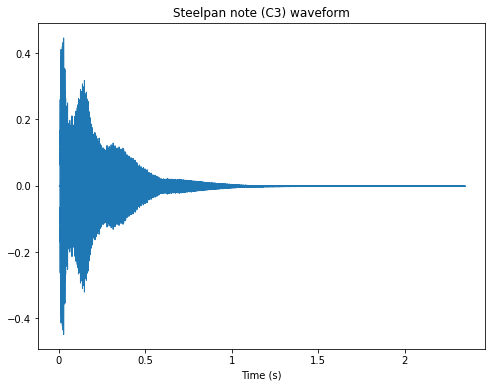

In [ ]:
audio, _ = librosa.load('/content/SASSE_48/validation/60_valid_sample_7.wav', sr=sr)

# plot sample
fig, ax = plt.subplots(figsize=(8,6))
librosa.display.waveshow(audio, sr=sr, ax=ax,
                         x_axis='s')
ax.set(title='Steelpan note (C3) waveform')
plt.show()

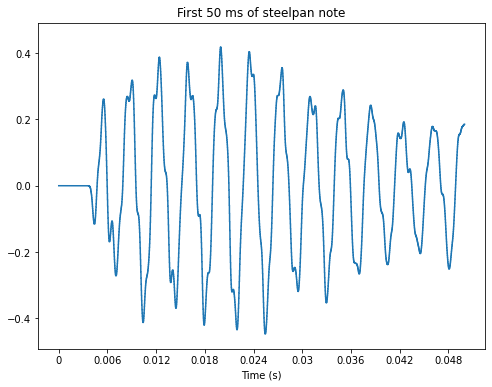

In [ ]:
lat, attack_start, attack_stop = attack_time(audio)
start, stop = int(sr * attack_start), int(sr * attack_stop)

#plot first 50 ms
fig, ax = plt.subplots(figsize=(8,6))
librosa.display.waveshow(audio[:int(0.05*sr)], sr=sr, ax=ax,
                         x_axis='s')
ax.set(title='First 50 ms of steelpan note')
plt.show()

Attack length: 15.020834282040596 ms
Number of samples: 721


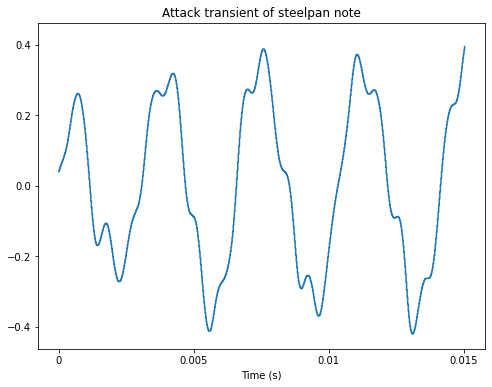

In [ ]:
# plot attack from 20% to 90% of envelope max value
print(f"Attack length: {(attack_stop - attack_start) * 1000} ms")
print(f"Number of samples: {int((attack_stop - attack_start)*sr)}")
fig, ax = plt.subplots(figsize=(8,6))
librosa.display.waveshow(audio[int(attack_start * sr) : int(attack_stop * sr)],
                         sr=sr, ax=ax, x_axis='s')
ax.set(title='Attack transient of steelpan note')
plt.show()

In [ ]:
print("Ground truth: 60\n")

yin_out = librosa.yin(audio[:frame_size], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
yin_out = librosa.hz_to_midi(yin_out)
print("Yin pitch estimations")
print(f"First 50 ms: {np.round(yin_out,2)}")

yin_out = librosa.yin(audio[start:stop], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
yin_out = librosa.hz_to_midi(yin_out)
print(f"Attack transient: {np.round(yin_out, 2)}")

Ground truth: 60

Yin pitch estimations
First 50 ms: [47.59 48.48 47.44 46.87 46.75]
Attack transient: [46.92 47.33]


In [ ]:
print("Ground truth: 60\n")

pyin_out, _, _ = librosa.pyin(audio[:frame_size], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
pyin_out = librosa.hz_to_midi(pyin_out)
print("pYin pitch estimations")
print(f"First 50ms: {pyin_out}")

pyin_out, _, _ = librosa.pyin(audio[start:stop], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
pyin_out = librosa.hz_to_midi(pyin_out)
print(f"Attack transient: {pyin_out}")

Ground truth: 60

pYin pitch estimations
First 50ms: [ nan 48.5 47.4 46.9 46.7]
Attack transient: [nan nan]


In [ ]:
print("Ground truth: 60\n")

time, crepe_pred, _, _ = crepe.predict(audio, sr, viterbi=True)
crepe_pred = librosa.hz_to_midi(crepe_pred)
print("Crepe pitch estimations")
print(f"First 50 ms: {np.round(crepe_pred,2)}")

time, crepe_pred, _, _ = crepe.predict(audio[start:stop], sr, viterbi=True)
crepe_pred = librosa.hz_to_midi(crepe_pred)
print(f"Attack transient: {np.round(crepe_pred,2)}")

Ground truth: 60

8/8 [==============================] - 9s 102ms/step
Crepe pitch estimations
First 50 ms: [60.65 60.51 60.46 60.42 60.32 60.36 60.46 60.46 60.4  60.27 60.18 60.16
 60.14 60.12 60.14 60.15 60.14 60.12 60.09 60.08 60.09 60.11 60.13 60.13
 60.12 60.09 60.09 60.09 60.11 60.11 60.11 60.11 60.09 60.06 60.07 60.09
 60.09 60.09 60.08 60.08 60.07 60.08 60.08 60.1  60.08 60.08 60.07 60.07
 60.08 60.09 60.1  60.09 60.08 60.07 60.07 60.07 60.11 60.12 60.12 60.1
 60.08 60.08 60.08 60.08 60.09 60.08 60.06 60.07 60.07 60.08 60.08 60.08
 60.07 60.07 60.06 60.07 60.08 60.09 60.07 60.06 60.07 60.07 60.06 60.08
 60.08 60.07 60.06 60.06 60.07 60.08 60.07 60.06 60.07 60.06 60.07 60.08
 60.1  60.08 60.07 60.07 60.07 60.07 60.09 60.09 60.1  60.07 60.06 60.07
 60.09 60.08 60.09 60.08 60.07 60.09 60.1  60.1  60.08 60.07 60.07 60.08
 60.07 60.09 60.08 60.07 60.07 60.07 60.06 60.06 60.07 60.1  60.08 60.07
 60.07 60.07 60.09 60.09 60.06 60.07 60.08 60.1  60.1  60.09 60.1  60.09
 60.07 60.07 60.0

### What this shows

What the tests show for performing this on just the attack portion as determined by Essentia is that accuracy on such a small section is difficult and the algorithms clearly rely on longer contexts for accuracy. This is especially true for CREPE since it operates only on 1024 sample frames at 16 kHz, which is 64 ms long.

## What if we look at the audio in reverse?

8/8 [==============================] - 0s 44ms/step
50 ms: [55.63 55.53 54.5  53.96 53.08 52.61 52.05 51.39 50.87 50.03 48.37 47.3
 47.77 47.66 47.98 47.92 47.78 47.64 49.17 50.85 51.99 53.65 54.84 54.87
 54.94 54.88 54.92 55.02 56.5  56.3  56.65 58.   59.65 59.89 59.73 59.54
 59.37 59.81 60.16 60.18 60.16 60.07 60.28 60.01 59.71 59.79 59.91 60.01
 60.08 60.07 60.01 60.03 59.99 60.06 60.02 59.98 60.09 60.12 60.07 60.01
 59.98 60.01 60.01 60.   59.95 60.1  60.27 60.36 60.27 60.09 60.01 59.98
 60.03 60.05 60.11 60.15 60.11 60.11 60.08 60.07 60.04 60.02 60.04 60.07
 60.09 60.11 60.1  60.07 60.05 60.06 60.06 60.07 60.07 60.07 60.09 60.08
 60.07 60.06 60.05 60.07 60.06 60.05 60.05 60.06 60.07 60.08 60.06 60.05
 60.04 60.05 60.07 60.06 60.07 60.07 60.07 60.07 60.06 60.04 60.08 60.08
 60.1  60.08 60.08 60.06 60.08 60.06 60.08 60.06 60.06 60.05 60.06 60.07
 60.07 60.06 60.06 60.05 60.05 60.06 60.07 60.06 60.07 60.05 60.06 60.05
 60.06 60.06 60.05 60.05 60.05 60.05 60.06 60.06 60.06 60.06 60.05

/usr/local/lib/python3.8/dist-packages/librosa/util/utils.py:198: UserWarning: librosa.util.frame called with axis=-1 on a non-contiguous input. This will result in a copy.
  warnings.warn(


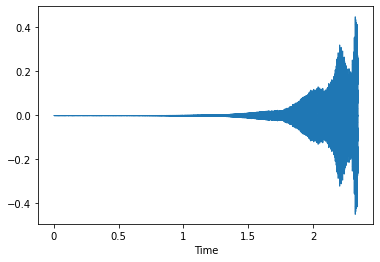

In [ ]:
audio_rev = audio[::-1]

time, crepe_pred, _, _ = crepe.predict(audio_rev, sr, viterbi=True)
crepe_pred = librosa.hz_to_midi(crepe_pred)
print(f"50 ms: {np.round(crepe_pred,2)}")

#plot first 50 ms
fig, ax = plt.subplots()
librosa.display.waveshow(audio_rev, sr=sr, ax=ax)
plt.show()

### Thoughts on bi-directional analysis

Interestingly, what this cell shows is that doing pitch detection in reverse gives different results. My intuition is that this could be caused by one of two things:
1. You are just catching the audio at different points. This would be similar to changing the start point of the analysis.
  - I'm leaning against this, however, since you'd think that the results would still be similar. The beginnings and endings of the two prediction arrays vary quite a bit, however. This leads me to my second hypothesis:
2. That since this is probabilistic (it uses the Viterbi algorithm) - and thus dependent on previous predictions - the direction of the processing affects the output values. The question then becomes, can we improve pitch detection results by performing bi-directional analysis?
  - An initial test of this would be to analyze an annotated dataset both forwards and backwards and then combining/averaging that data somehow. Another intersting approach would be to build a pitch detection architecture that does the bi-directional analysis by default.
  - The unfortunate limitation of this method would be that it really only works for offline analysis.

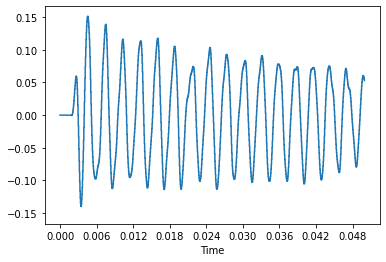

In [ ]:
audio_02, sr = librosa.load('/content/SASSE_48/validation/65_valid_sample_33.wav')

#plot first 50 ms
fig, ax = plt.subplots()
librosa.display.waveshow(audio_02[:int(0.05*sr)], sr=sr, ax=ax)
plt.show()

In [ ]:
yin_out = librosa.yin(audio_02[:frame_size], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
yin_out = librosa.hz_to_midi(yin_out)
print(np.round(yin_out,2))

[65.26 65.33 65.25 65.1  65.01]


In [ ]:
pyin_out, _, _ = librosa.pyin(audio_02[:frame_size], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
pyin_out = librosa.hz_to_midi(pyin_out)
print(pyin_out)

[ nan 65.3 65.2 65.1 65. ]


In [ ]:
time, crepe_pred, _, _ = crepe.predict(audio_02[:frame_size], sr, viterbi=True)
crepe_pred = librosa.hz_to_midi(crepe_pred)
print(np.round(crepe_pred,2))

1/1 [==============================] - 0s 432ms/step
[65.04 65.02 65.07 65.04 64.99 65.01 65.01 65.   65.   64.98]


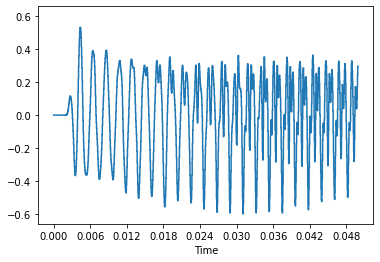

In [ ]:
audio_03, sr = librosa.load('/content/SASSE_48/validation/70_valid_sample_86.wav')

#plot first 50 ms
fig, ax = plt.subplots()
librosa.display.waveshow(audio_03[:int(0.05*sr)], sr=sr, ax=ax)
plt.show()

In [ ]:
yin_out = librosa.yin(audio_03[:frame_size], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
yin_out = librosa.hz_to_midi(yin_out)
print(np.round(yin_out,2))

[70.06 70.17 70.06 70.05 70.06]


In [ ]:
pyin_out, _, _ = librosa.pyin(audio_03[:frame_size], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
pyin_out = librosa.hz_to_midi(pyin_out)
print(pyin_out)

[ nan 70.2 70.1 70.  70.1]


In [ ]:
time, crepe_pred, _, _ = crepe.predict(audio_03[:frame_size], sr, viterbi=True)
crepe_pred = librosa.hz_to_midi(crepe_pred)
print(np.round(crepe_pred,2))

1/1 [==============================] - 0s 17ms/step
[70.07 70.03 70.03 70.05 70.04 70.05 70.05 70.03 70.   70.  ]


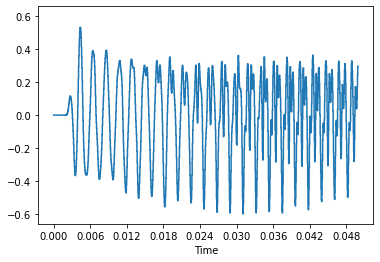

In [ ]:
audio_04, sr = librosa.load('/content/SASSE_48/validation/71_valid_sample_19.wav')

#plot first 50 ms
fig, ax = plt.subplots()
librosa.display.waveshow(audio_03[:int(0.05*sr)], sr=sr, ax=ax)
plt.show()

In [ ]:
yin_out = librosa.yin(audio_04[:frame_size], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
yin_out = librosa.hz_to_midi(yin_out)
print(np.round(yin_out,2))

[71.15 71.26 71.14 71.06 71.07]


In [ ]:
pyin_out, _, _ = librosa.pyin(audio_04[:frame_size], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
pyin_out = librosa.hz_to_midi(pyin_out)
print(pyin_out)

[ nan 71.3 71.1 71.1 71.1]


In [ ]:
time, crepe_pred, _, _ = crepe.predict(audio_04[:frame_size], sr, viterbi=True)
crepe_pred = librosa.hz_to_midi(crepe_pred)
print(np.round(crepe_pred,2))

1/1 [==============================] - 0s 19ms/step
[71.24 71.13 71.11 71.08 71.06 71.06 71.04 71.03 71.02 71.03]


## Average attack transient length

In [ ]:
calc_avg_transient = True

In [ ]:
dir = '/content/SASSE_48/train'
sr = 48000
total_attack_time = 0
num_files = 0

attack_time = es.LogAttackTime(sampleRate=sr, startAttackThreshold=0.1, stopAttackThreshold=0.9)

if calc_avg_transient:
  for (dir_path, _, filenames) in os.walk(dir):
      num_files = len(filenames)
      for filename in filenames:
        file_path = os.path.join(dir_path, filename)

        audio, _ = librosa.load(file_path, sr=sr)
        _, attack_start, attack_stop = attack_time(audio)
        attack_length = attack_stop - attack_start
        
        total_attack_time += attack_length
        num_files += 1

print(f"Average attack length: {total_attack_time / num_files} s")
print(f"Average attack length: {total_attack_time * 1000 / num_files} ms")

Average attack length: 0.008026080411385358 s
Average attack length: 8.026080411385356 ms


In [ ]:
print(num_files)

15862


In [ ]:
# count number of files in SASSE
for (dir_path, _, filenames) in os.walk('/content/SASSE_48/train'):
  num_files = len(filenames)
  print(f"Training set: {num_files}")

for (dir_path, _, filenames) in os.walk('/content/SASSE_48/validation'):
  num_files = len(filenames)
  print(f"Validation set: {num_files}")

for (dir_path, _, filenames) in os.walk('/content/SASSE_48/test'):
  num_files = len(filenames)
  print(f"Test set: {num_files}")

Training set: 7931
Validation set: 2680
Test set: 2702


# Evaluating Yin, pYin, and CRéPE

## Load dataframe

Load the csv file stored on Github and convert it to a Pandas dataframe for adding new data to.

In [ ]:
# prep
csv_path = 'https://raw.githubusercontent.com/malloyca/steelpan-pitch/main/onset-pitch/steelpan_pitch_onset_evaluation.csv'
evaluation_df = pd.read_csv(csv_path)

In [ ]:
evaluation_df.head()

,Unnamed: 0,dataset,algo,samplerate,frame_length,hop_size,smp_length,frames_analyzed,rpa50,rpa50_std,rpa25,rpa25_std,rpa10,rpa10_std,rca50,rca50_std,rca25,rca25_std,rca10,rca10_std
0,0,SASSE_16/validation,yin,16000,1024,512,0.05,5360,0.7716417910447761,0.009403242525833003,0.6076492537313433,0.010937679141602884,0.27705223880597013,0.010025262287911754,0.7792910447761194,0.009290118923286805,0.621455223880597,0.010864881735361235,0.30522388059701494,0.01031556807277578
1,1,['SASSE_16/validation'],yin,[16000],[1024],[160],[0.05],[16080],[0.7916044776119403],[0.0052529000655192485],[0.5893656716417911],[0.006362398548675664],[0.28389303482587064],[0.0058313236126906],[0.8026119402985075],[0.005147710004731096],[0.6080845771144279],[0.006313628112001445],[0.3231965174129353],[0.006048747483391886]
2,2,SASSE_16/validation,pyin,16000,1024,512,0.05,5102,0.8806350450803606,0.00744406269642824,0.7473539788318306,0.00997684047136621,0.5270482163857311,0.011463235871759634,0.8833790670325362,0.007369455971710193,0.7538220305762446,0.009890827468799167,0.5564484515876127,0.011406650629166112
3,3,SASSE_16/validation,pyin,16000,1024,160,0.05,15523,0.8659408619467887,0.0044848543911409225,0.6726792501449462,0.006176561978807632,0.4504928171100947,0.006549175696554466,0.8747020550151389,0.004357707408094822,0.6899439541325775,0.006088117533576466,0.49301037170650003,0.006580874135730589


## YIN evaluation

In [ ]:
# use this to enable/disable yin evaluation
evaluate_yin = False

dataset_name = 'SASSE_16/validation'
dataset_path = '/content/SASSE_16/validation'
samplerate = 16000
frame_size = 1024
hop_size = frame_size // 2
#hop_size = 160
attack_length = 0.05 # seconds

In [ ]:
def get_yin_estimation(sample_path, samplerate, target, frame_size, hop_size,
                       attack_length=0.05):
  
  # load sample
  loader = es.MonoLoader(filename=sample_path, sampleRate=samplerate)
  audio = loader()

  # trim the sample to the first 50 ms
  start_stop = es.StartStopSilence(threshold=-60)
  start_frame, stop_frame = 0, 0
  for frame in es.FrameGenerator(audio, frame_size, hop_size):
    start_frame, stop_frame = start_stop(frame)

  start_time = float(start_frame * hop_size) / float(samplerate)
  frame_length = frame_size / samplerate
  end_time = start_time + attack_length #+ frame_length # pad the attack length by frame_length
  
  # trim audio
  trimmer = es.Trimmer(startTime=start_time, endTime=end_time,
                       sampleRate=samplerate)
  trimmed_audio = trimmer(audio)

  # get yin pitch estimations
  pitch_estimations = librosa.yin(trimmed_audio, fmin=librosa.note_to_hz('C2'),
                                  fmax=librosa.note_to_hz('C7'), sr=samplerate,
                                  frame_length=frame_size, hop_length=hop_size)
  
  # filter out NaNs
  pitch_estimations = pitch_estimations[~np.isnan(pitch_estimations)]

  # populate array of target values to match size of estimations array
  targets = [float(target)] * pitch_estimations.shape[0]

  return pitch_estimations, targets

In [ ]:
# test to make sure it's working
get_yin_estimation('/content/SASSE_tiny_16/train/60_train_sample_101.wav',
                   samplerate=16000, target=60, frame_size=frame_size, hop_size=512)

(array([261.16396013, 261.54450673]), [60.0, 60.0])

In [ ]:
def process_folder_yin(directory, samplerate, frame_size, hop_size,
                        attack_length=0.05):
  folder_pitches = []
  folder_targets = []
  file_count = 0
  count = 0

  for (dir_path, _, filenames) in os.walk(directory):
    num_files = len(filenames)
    for filename in filenames:
      file_path = os.path.join(dir_path, filename)

      # in my formatting, the target is given by the first numbers in the filename
      target = filename.split("_")[0]
      pitches, targets = get_yin_estimation(file_path, samplerate=samplerate,
                                            target=target,
                                            frame_size=frame_size,
                                            hop_size=hop_size,
                                            attack_length=attack_length)
      
      folder_pitches.append(pitches)
      folder_targets.append(targets)

      file_count += 1
      if (file_count % 100) == 0:
        print(f'Progress: {file_count}/{num_files}')

  folder_pitches = np.concatenate(folder_pitches)
  folder_targets = np.concatenate(folder_targets)
  print(f"Num files processed: {file_count}")
  return folder_pitches, folder_targets

In [ ]:
if evaluate_yin:
  yin_estimates, yin_targets = process_folder_yin(dataset_path, samplerate=16000,
                                                  frame_size=frame_size, hop_size=hop_size,
                                                  attack_length=attack_length)

Progress: 100/2680
Progress: 200/2680
Progress: 300/2680
Progress: 400/2680
Progress: 500/2680
Progress: 600/2680
Progress: 700/2680
Progress: 800/2680
Progress: 900/2680
Progress: 1000/2680
Progress: 1100/2680
Progress: 1200/2680
Progress: 1300/2680
Progress: 1400/2680
Progress: 1500/2680
Progress: 1600/2680
Progress: 1700/2680
Progress: 1800/2680
Progress: 1900/2680
Progress: 2000/2680
Progress: 2100/2680
Progress: 2200/2680
Progress: 2300/2680
Progress: 2400/2680
Progress: 2500/2680
Progress: 2600/2680
Num files processed: 2680


In [ ]:
if evaluate_yin:
  print(yin_estimates.shape, yin_targets.shape)

(16080,) (16080,)


### Raw pitch accuracy

In [ ]:
evaluation_df.head()

,dataset,algo,samplerate,frame_length,hop_size,smp_length,frames_analyzed,rpa50,rpa50_std,rpa25,rpa25_std,rpa10,rpa10_std,rca50,rca50_std,rca25,rca25_std,rca10,rca10_std
0,SASSE_16/validation,True,16000,1024,512,0.05,5360,0.771642,0.009403,0.607649,0.010938,0.277052,0.010025,0.779291,0.00929,0.621455,0.010865,0.305224,0.010316


In [ ]:
if evaluate_yin:
  yin_rpa_50_matches = np.where(np.abs(librosa.hz_to_midi(yin_estimates) - yin_targets) < 0.5)
  yin_rpa_25_matches = np.where(np.abs(librosa.hz_to_midi(yin_estimates) - yin_targets) < 0.25)
  yin_rpa_10_matches = np.where(np.abs(librosa.hz_to_midi(yin_estimates) - yin_targets) < 0.1)

In [ ]:
if evaluate_yin:
  yin_rpa_50 = yin_rpa_50_matches[0].shape[0] / len(yin_targets)
  print(f"50 cent raw pitch accuracy: {yin_rpa_50}")
  yin_rpa_25 = yin_rpa_25_matches[0].shape[0] / len(yin_targets)
  print(f"25 cent raw pitch accuracy: {yin_rpa_25}")
  yin_rpa_10 = yin_rpa_10_matches[0].shape[0] / len(yin_targets)
  print(f"10 cent raw pitch accuracy: {yin_rpa_10}")

50 cent raw pitch accuracy: 0.7916044776119403
25 cent raw pitch accuracy: 0.5893656716417911
10 cent raw pitch accuracy: 0.28389303482587064


I got this method of calculating the confidence interval from [Machine Learning Mastery](https://machinelearningmastery.com/confidence-intervals-for-machine-learning/). These calculations are made for a 95% confidence interval.

In [ ]:
if evaluate_yin:
  yin_rpa_50_conf_int = 1.64 * np.sqrt( (yin_rpa_50 * (1 - yin_rpa_50))  / len(yin_targets))
  print(f"50 cent rpa std: {yin_rpa_50_conf_int}")
  yin_rpa_25_conf_int = 1.64 * np.sqrt( (yin_rpa_25 * (1 - yin_rpa_25))  / len(yin_targets))
  print(f"25 cent rpa std: {yin_rpa_25_conf_int}")
  yin_rpa_10_conf_int = 1.64 * np.sqrt( (yin_rpa_10 * (1 - yin_rpa_10))  / len(yin_targets))
  print(f"10 cent rpa std: {yin_rpa_10_conf_int}")


  #yin_rpa_diffs = np.abs(librosa.hz_to_midi(yin_estimates) - yin_targets)

  #yin_rpa_50_std = np.where(np.abs(yin_rpa_diffs) > 0.5, yin_rpa_diffs, 0)
  #print(f"50 cent rpa std: {yin_rpa_50_std.std()}")
  #yin_rpa_25_std = np.where(np.abs(yin_rpa_diffs) > 0.25, yin_rpa_diffs, 0)
  #print(f"25 cent rpa std: {yin_rpa_25_std.std()}")
  #yin_rpa_10_std = np.where(np.abs(yin_rpa_diffs) > 0.1, yin_rpa_diffs, 0)
  #print(f"10 cent rpa std: {yin_rpa_10_std.std()}")

50 cent rpa std: 0.0052529000655192485
25 cent rpa std: 0.006362398548675664
10 cent rpa std: 0.0058313236126906


### Raw chroma accuracy

In [ ]:
if evaluate_yin:
  # offset by 0.5 to account for [11.5,12.5] as the octave error range when taking the modulo
  yin_rca_50_matches = np.where(np.fmod( np.abs(librosa.hz_to_midi(yin_estimates) - yin_targets + 0.5), 12 ) < 1.0)
  yin_rca_25_matches = np.where(np.fmod( np.abs(librosa.hz_to_midi(yin_estimates) - yin_targets + 0.25), 12 ) < 0.5)
  yin_rca_10_matches = np.where(np.fmod( np.abs(librosa.hz_to_midi(yin_estimates) - yin_targets + 0.1), 12 ) < 0.2)

In [ ]:
if evaluate_yin:
  yin_rca_50 = yin_rca_50_matches[0].shape[0] / len(yin_targets)
  print(f"50 cent raw chroma accuracy: {yin_rca_50}")
  yin_rca_25 = yin_rca_25_matches[0].shape[0] / len(yin_targets)
  print(f"25 cent raw chroma accuracy: {yin_rca_25}")
  yin_rca_10 = yin_rca_10_matches[0].shape[0] / len(yin_targets)
  print(f"10 cent raw chroma accuracy: {yin_rca_10}")

50 cent raw chroma accuracy: 0.8026119402985075
25 cent raw chroma accuracy: 0.6080845771144279
10 cent raw chroma accuracy: 0.3231965174129353


In [ ]:
if evaluate_yin:
  yin_rca_50_conf_int = 1.64 * np.sqrt( (yin_rca_50 * (1 - yin_rca_50))  / len(yin_targets))
  print(f"50 cent rca std: {yin_rca_50_conf_int}")
  yin_rca_25_conf_int = 1.64 * np.sqrt( (yin_rca_25 * (1 - yin_rca_25))  / len(yin_targets))
  print(f"25 cent rca std: {yin_rca_25_conf_int}")
  yin_rca_10_conf_int = 1.64 * np.sqrt( (yin_rca_10 * (1 - yin_rca_10))  / len(yin_targets))
  print(f"10 cent rca std: {yin_rca_10_conf_int}")

  #yin_rca_50_diffs = np.fmod(np.abs(librosa.hz_to_midi(yin_estimates) - yin_targets + 0.5), 12)
  #yin_rca_25_diffs = np.fmod(np.abs(librosa.hz_to_midi(yin_estimates) - yin_targets + 0.25), 12)
  #yin_rca_10_diffs = np.fmod(np.abs(librosa.hz_to_midi(yin_estimates) - yin_targets + 0.1), 12)

  #yin_rca_50_std = np.where(yin_rca_50_diffs > 1.0, yin_rca_50_diffs, 0)
  #print(f"50 cent rca std: {yin_rca_50_std.std()}")
  #yin_rca_25_std = np.where(yin_rca_25_diffs > 0.5, yin_rca_25_diffs, 0)
  #print(f"25 cent rca std: {yin_rca_25_std.std()}")
  #yin_rca_10_std = np.where(yin_rca_10_diffs > 0.2, yin_rca_10_diffs, 0)
  #print(f"10 cent rca std: {yin_rca_10_std.std()}")


50 cent rca std: 0.005147710004731096
25 cent rca std: 0.006313628112001445
10 cent rca std: 0.006048747483391886


### Saving the data

In [ ]:
# change to True to save this to the df
save_yin_eval = False

In [ ]:
evaluation_df.head()

,dataset,algo,samplerate,frame_length,hop_size,smp_length,frames_analyzed,rpa50,rpa50_std,rpa25,rpa25_std,rpa10,rpa10_std,rca50,rca50_std,rca25,rca25_std,rca10,rca10_std
0,SASSE_16/validation,True,16000,1024,512,0.05,5360,0.771642,0.009403,0.607649,0.010938,0.277052,0.010025,0.779291,0.00929,0.621455,0.010865,0.305224,0.010316


In [ ]:
# add data to dataframe
if evaluate_yin:
  if save_yin_eval:
    df_row = {
        'dataset': dataset_name,
        'algo': 'yin',
        'samplerate': samplerate,
        'frame_length': frame_size,
        'hop_size': hop_size,
        'smp_length': attack_length,
        'frames_analyzed': yin_estimates.shape[0],
        'rpa50': yin_rpa_50,
        'rpa50_std': yin_rpa_50_conf_int,
        'rpa25': yin_rpa_25,
        'rpa25_std': yin_rpa_25_conf_int,
        'rpa10': yin_rpa_10,
        'rpa10_std': yin_rpa_10_conf_int,
        'rca50': yin_rca_50,
        'rca50_std': yin_rca_50_conf_int,
        'rca25': yin_rca_25,
        'rca25_std': yin_rca_25_conf_int,
        'rca10': yin_rca_10,
        'rca10_std': yin_rca_10_conf_int
    }

    #evaluation_df = pd.DataFrame.from_dict(df_row, orient='columns')
    evaluation_df = evaluation_df.append(df_row, ignore_index=True)
    save_yin_eval = False

In [ ]:
evaluation_df.tail()

,dataset,algo,samplerate,frame_length,hop_size,smp_length,frames_analyzed,rpa50,rpa50_std,rpa25,rpa25_std,rpa10,rpa10_std,rca50,rca50_std,rca25,rca25_std,rca10,rca10_std
0,SASSE_16/validation,yin,16000,1024,512,0.05,5360,0.771642,0.009403,0.607649,0.010938,0.277052,0.010025,0.779291,0.00929,0.621455,0.010865,0.305224,0.010316
1,[SASSE_16/validation],yin,[16000],[1024],[160],[0.05],[16080],[0.7916044776119403],[0.0052529000655192485],[0.5893656716417911],[0.006362398548675664],[0.28389303482587064],[0.0058313236126906],[0.8026119402985075],[0.005147710004731096],[0.6080845771144279],[0.006313628112001445],[0.3231965174129353],[0.006048747483391886]


## pYin evaluation

In [ ]:
# use this to enable/disable pyin evaluation
evaluate_pyin = True

dataset_name = 'SASSE_16/validation'
dataset_path = '/content/SASSE_16/validation'
samplerate = 16000
frame_size = 128
#hop_size = frame_size // 2
hop_size = 64
onset = False
attack_length = 0.05 # seconds

In [ ]:
def get_pyin_estimation(sample_path, samplerate, target, frame_size, hop_size,
                        attack_length=0.05):

  # load sample
  loader = es.MonoLoader(filename=sample_path, sampleRate=samplerate)
  audio = loader()

  # trim the sample to the first 50 ms
  start_stop = es.StartStopSilence(threshold=-60)
  start_frame, stop_frame = 0, 0
  for frame in es.FrameGenerator(audio, frame_size, hop_size):
    start_frame, stop_frame = start_stop(frame)

  start_time = float(start_frame * hop_size) / float(samplerate)
  bonus_time = hop_size / samplerate
  #end_time = start_time + attack_length + bonus_time
  end_time = float(stop_frame * hop_size) / float(samplerate)

  # trim audio
  trimmer = es.Trimmer(startTime=start_time, endTime=end_time,
                       sampleRate=samplerate)
  trimmed_audio = trimmer(audio)

  # get pyin pitch estimations
  pitch_estimations, _, _ = librosa.pyin(trimmed_audio, fmin=librosa.note_to_hz('C2'),
                               fmax=librosa.note_to_hz('C7'), sr=samplerate,
                               frame_length=frame_size, hop_length=hop_size)
  
  # filter out NaNs
  pitch_estimations = pitch_estimations[~np.isnan(pitch_estimations)]
  
  # populate array of target values to match size of estimations array
  targets = [float(target)] * pitch_estimations.shape[0]

  return pitch_estimations, targets

In [ ]:
# test to make sure it's working
get_pyin_estimation('/content/SASSE_tiny_16/train/60_train_sample_101.wav',
                   samplerate=16000, target=60, frame_size=1024, hop_size=512)

(array([261.6255653 , 263.14114678, 261.6255653 , 263.14114678,
        263.14114678, 263.14114678, 263.14114678, 261.6255653 ,
        263.14114678, 263.14114678, 261.6255653 , 263.14114678,
        263.14114678, 263.14114678, 261.6255653 , 261.6255653 ,
        261.6255653 , 261.6255653 , 261.6255653 , 261.6255653 ,
        261.6255653 , 261.6255653 , 261.6255653 , 261.6255653 ,
        261.6255653 , 261.6255653 , 261.6255653 , 261.6255653 ,
        261.6255653 , 261.6255653 , 261.6255653 , 261.6255653 ,
        261.6255653 , 258.62053938, 260.11871293, 261.6255653 ,
        261.6255653 , 261.6255653 , 263.14114678, 261.6255653 ,
        263.14114678, 261.6255653 , 260.11871293, 261.6255653 ,
        261.6255653 , 263.14114678, 261.6255653 , 263.14114678,
        261.6255653 , 260.11871293]),
 [60.0,
  60.0,
  60.0,
  60.0,
  60.0,
  60.0,
  60.0,
  60.0,
  60.0,
  60.0,
  60.0,
  60.0,
  60.0,
  60.0,
  60.0,
  60.0,
  60.0,
  60.0,
  60.0,
  60.0,
  60.0,
  60.0,
  60.0,
  60.0,
  

In [ ]:
def process_folder_pyin(directory, samplerate, frame_size, hop_size,
                        attack_length=0.05):
  folder_pitches = []
  folder_targets = []
  file_count = 0
  count = 0

  for (dir_path, _, filenames) in os.walk(directory):
    num_files = len(filenames)
    for filename in filenames:
      file_path = os.path.join(dir_path, filename)

      # in my formatting, the target is given by the first numbers in the filename
      target = filename.split("_")[0]
      pitches, targets = get_pyin_estimation(file_path, samplerate=samplerate,
                                             target=target,
                                             frame_size=frame_size,
                                             hop_size=hop_size,
                                             attack_length=attack_length)
      
      folder_pitches.append(pitches)
      folder_targets.append(targets)

      file_count += 1
      if file_count % 100 == 0:
        print(f'Progress: {file_count}/{num_files}')

  folder_pitches = np.concatenate(folder_pitches)
  folder_targets = np.concatenate(folder_targets)
  print(f"Num files processed: {file_count}")
  return folder_pitches, folder_targets

In [ ]:
if evaluate_pyin:
  pyin_estimates, pyin_targets = process_folder_pyin(dataset_path, samplerate=16000,
                                                    frame_size=frame_size, hop_size=hop_size,
                                                    attack_length=attack_length)

Progress: 100/2680
Progress: 200/2680
Progress: 300/2680
Progress: 400/2680
Progress: 500/2680
Progress: 600/2680
Progress: 700/2680
Progress: 800/2680
Progress: 900/2680
Progress: 1000/2680
Progress: 1100/2680
Progress: 1200/2680
Progress: 1300/2680
Progress: 1400/2680
Progress: 1500/2680
Progress: 1600/2680
Progress: 1700/2680
Progress: 1800/2680
Progress: 1900/2680
Progress: 2000/2680
Progress: 2100/2680
Progress: 2200/2680
Progress: 2300/2680
Progress: 2400/2680
Progress: 2500/2680
Progress: 2600/2680
Num files processed: 2680


In [ ]:
if evaluate_pyin:
  print(pyin_estimates.shape, pyin_targets.shape)

(555966,) (555966,)


### Raw pitch accuracy

In [ ]:
if evaluate_pyin:
  pyin_rpa_50_matches = np.where(np.abs(librosa.hz_to_midi(pyin_estimates) - pyin_targets) < 0.5)
  pyin_rpa_25_matches = np.where(np.abs(librosa.hz_to_midi(pyin_estimates) - pyin_targets) < 0.25)
  pyin_rpa_10_matches = np.where(np.abs(librosa.hz_to_midi(pyin_estimates) - pyin_targets) < 0.1)

In [ ]:
if evaluate_pyin:
  pyin_rpa_50 = pyin_rpa_50_matches[0].shape[0] / len(pyin_targets)
  print(f"50 cent accuracy: {pyin_rpa_50}")
  pyin_rpa_25 = pyin_rpa_25_matches[0].shape[0] / len(pyin_targets)
  print(f"25 cent accuracy: {pyin_rpa_25}")
  pyin_rpa_10 = pyin_rpa_10_matches[0].shape[0] / len(pyin_targets)
  print(f"10 cent accuracy: {pyin_rpa_10}")

50 cent accuracy: 0.7614998039448455
25 cent accuracy: 0.6877416964346741
10 cent accuracy: 0.5226758470841742


In [ ]:
if evaluate_pyin:
  pyin_rpa_50_conf_int = 1.64 * np.sqrt( (pyin_rpa_50 * (1 - pyin_rpa_50))  / len(pyin_targets))
  print(f"50 cent rpa std: {pyin_rpa_50_conf_int}")
  pyin_rpa_25_conf_int = 1.64 * np.sqrt( (pyin_rpa_25 * (1 - pyin_rpa_25))  / len(pyin_targets))
  print(f"25 cent rpa std: {pyin_rpa_25_conf_int}")
  pyin_rpa_10_conf_int = 1.64 * np.sqrt( (pyin_rpa_10 * (1 - pyin_rpa_10))  / len(pyin_targets))
  print(f"10 cent rpa std: {pyin_rpa_10_conf_int}")

50 cent rpa std: 0.000937343990904893
25 cent rpa std: 0.001019270388005953
10 cent rpa std: 0.0010986077353507214


### Raw chroma accuracy

In [ ]:
if evaluate_pyin:
  # offset by 0.5 to account for [11.5,12.5] as the octave error range when taking the modulo
  pyin_rca_50_matches = np.where(np.fmod( np.abs(librosa.hz_to_midi(pyin_estimates) - pyin_targets + 0.5), 12 ) < 1.0)
  pyin_rca_25_matches = np.where(np.fmod( np.abs(librosa.hz_to_midi(pyin_estimates) - pyin_targets + 0.25), 12 ) < 0.5)
  pyin_rca_10_matches = np.where(np.fmod( np.abs(librosa.hz_to_midi(pyin_estimates) - pyin_targets + 0.1), 12 ) < 0.2)

In [ ]:
if evaluate_pyin:
  pyin_rca_50 = pyin_rca_50_matches[0].shape[0] / len(pyin_targets)
  print(f"50 cent raw chroma accuracy: {pyin_rca_50}")
  pyin_rca_25 = pyin_rca_25_matches[0].shape[0] / len(pyin_targets)
  print(f"25 cent raw chroma accuracy: {pyin_rca_25}")
  pyin_rca_10 = pyin_rca_10_matches[0].shape[0] / len(pyin_targets)
  print(f"10 cent raw chroma accuracy: {pyin_rca_10}")

50 cent raw chroma accuracy: 0.773653424849721
25 cent raw chroma accuracy: 0.7125759488889608
10 cent raw chroma accuracy: 0.5887068633693427


In [ ]:
if evaluate_pyin:
  pyin_rca_50_conf_int = 1.64 * np.sqrt( (pyin_rca_50 * (1 - pyin_rca_50))  / len(pyin_targets))
  print(f"50 cent rca std: {pyin_rca_50_conf_int}")
  pyin_rca_25_conf_int = 1.64 * np.sqrt( (pyin_rca_25 * (1 - pyin_rca_25))  / len(pyin_targets))
  print(f"25 cent rca std: {pyin_rca_25_conf_int}")
  pyin_rca_10_conf_int = 1.64 * np.sqrt( (pyin_rca_10 * (1 - pyin_rca_10))  / len(pyin_targets))
  print(f"10 cent rca std: {pyin_rca_10_conf_int}")

50 cent rca std: 0.0009204070179967847
25 cent rca std: 0.0009953982307713601
10 cent rca std: 0.0010822934051962553


### Saving the data

In [ ]:
# change to True to save this to the df
save_pyin_eval = False

In [ ]:
evaluation_df.head()

,dataset,algo,samplerate,frame_length,hop_size,smp_length,frames_analyzed,rpa50,rpa50_std,rpa25,rpa25_std,rpa10,rpa10_std,rca50,rca50_std,rca25,rca25_std,rca10,rca10_std
0,SASSE_16/validation,yin,16000,1024,512,0.05,5360,0.771642,0.009403,0.607649,0.010938,0.277052,0.010025,0.779291,0.00929,0.621455,0.010865,0.305224,0.010316
1,[SASSE_16/validation],yin,[16000],[1024],[160],[0.05],[16080],[0.7916044776119403],[0.0052529000655192485],[0.5893656716417911],[0.006362398548675664],[0.28389303482587064],[0.0058313236126906],[0.8026119402985075],[0.005147710004731096],[0.6080845771144279],[0.006313628112001445],[0.3231965174129353],[0.006048747483391886]
2,SASSE_16/validation,pyin,16000,1024,512,0.05,5102,0.880635,0.007444,0.747354,0.009977,0.527048,0.011463,0.883379,0.007369,0.753822,0.009891,0.556448,0.011407


In [ ]:
evaluation_df = evaluation_df.reset_index(drop=True)

In [ ]:
# add data to dataframe
if evaluate_pyin:
  if save_pyin_eval:
    df_row = {
        'dataset': dataset_name,
        'algo': 'pyin',
        'samplerate': samplerate,
        'frame_length': frame_size,
        'hop_size': hop_size,
        'smp_length': attack_length,
        'frames_analyzed': pyin_estimates.shape[0],
        'rpa50': pyin_rpa_50,
        'rpa50_std': pyin_rpa_50_conf_int,
        'rpa25': pyin_rpa_25,
        'rpa25_std': pyin_rpa_25_conf_int,
        'rpa10': pyin_rpa_10,
        'rpa10_std': pyin_rpa_10_conf_int,
        'rca50': pyin_rca_50,
        'rca50_std': pyin_rca_50_conf_int,
        'rca25': pyin_rca_25,
        'rca25_std': pyin_rca_25_conf_int,
        'rca10': pyin_rca_10,
        'rca10_std': pyin_rca_10_conf_int
    }

    evaluation_df = evaluation_df.append(df_row, ignore_index=True)
    save_pyin_eval = False

    

In [ ]:
evaluation_df.tail()

,dataset,algo,samplerate,frame_length,hop_size,smp_length,frames_analyzed,rpa50,rpa50_std,rpa25,rpa25_std,rpa10,rpa10_std,rca50,rca50_std,rca25,rca25_std,rca10,rca10_std
0,SASSE_16/validation,yin,16000,1024,512,0.05,5360,0.771642,0.009403,0.607649,0.010938,0.277052,0.010025,0.779291,0.00929,0.621455,0.010865,0.305224,0.010316
1,[SASSE_16/validation],yin,[16000],[1024],[160],[0.05],[16080],[0.7916044776119403],[0.0052529000655192485],[0.5893656716417911],[0.006362398548675664],[0.28389303482587064],[0.0058313236126906],[0.8026119402985075],[0.005147710004731096],[0.6080845771144279],[0.006313628112001445],[0.3231965174129353],[0.006048747483391886]
2,SASSE_16/validation,pyin,16000,1024,512,0.05,5102,0.880635,0.007444,0.747354,0.009977,0.527048,0.011463,0.883379,0.007369,0.753822,0.009891,0.556448,0.011407
3,SASSE_16/validation,pyin,16000,1024,160,0.05,15523,0.865941,0.004485,0.672679,0.006177,0.450493,0.006549,0.874702,0.004358,0.689944,0.006088,0.49301,0.006581


## CRéPE Evaluation

In [ ]:
# use this to enable/disable crepe evaluation
evaluate_crepe = True

dataset_name = 'SASSE_16/validation'
dataset_path = '/content/SASSE_16/validation'
samplerate = 16000
frame_size = 1024 # this must be 1024 for crepe
step_size = 10
hop_size = int(samplerate * step_size / 1000)
model_capacity = 'full' # other options: 'large' 'medium' 'small' 'tiny'
attack_length = 0.05 # seconds

In [ ]:
def get_crepe_estimation(sample_path, samplerate, target, frame_size, hop_size,
                         attack_length=0.05, model_capacity='full', viterbi=False,
                         step_size=10):

  # load sample
  loader = es.MonoLoader(filename=sample_path, sampleRate=samplerate)
  audio = loader()

  # trim the sample to the first 50 ms
  start_stop = es.StartStopSilence(threshold=-60)
  start_frame, stop_frame = 0, 0
  for frame in es.FrameGenerator(audio, frame_size, hop_size):
    start_frame, stop_frame = start_stop(frame)

  start_time = float(start_frame * hop_size) / float(samplerate)
  #end_time = start_time + attack_length
  end_time = float(stop_frame * hop_size) / float(samplerate)

  # trim audio
  trimmer = es.Trimmer(startTime=start_time, endTime=end_time,
                       sampleRate=samplerate)
  trimmed_audio = trimmer(audio)

  # get crepe pitch estimations
  times, crepe_pred, _, _ = crepe.predict(trimmed_audio, sr=samplerate,
                                          model_capacity=model_capacity,
                                          viterbi=viterbi, step_size=step_size,
                                          verbose=0)
  
  # filter out NaNs
  crepe_pred = crepe_pred[~np.isnan(crepe_pred)]
  
  # populate array of target values to match size of estimations array
  targets = [float(target)] * crepe_pred.shape[0]

  return crepe_pred, targets

In [ ]:
def process_folder_crepe(directory, samplerate, frame_size, hop_size,
                         attack_length=0.05, model_capacity='full', viterbi=False,
                         step_size=10):
  folder_pitches = []
  folder_targets = []
  file_count = 0
  count = 0

  for (dir_path, _, filenames) in os.walk(directory):
    num_files = len(filenames)
    for filename in filenames:
      file_path = os.path.join(dir_path, filename)

      # in my formatting, the target is given by the first numbers in the filename
      target = filename.split("_")[0]
      pitches, targets = get_crepe_estimation(file_path, samplerate=samplerate,
                                              target=target,
                                              frame_size=frame_size,
                                              hop_size=hop_size,
                                              attack_length=attack_length,
                                              viterbi=viterbi,
                                              step_size=step_size)
      
      folder_pitches.append(pitches)
      folder_targets.append(targets)

      file_count += 1
      if (file_count % 100) == 0:
        print(f'Progress: {file_count}/{num_files}')

  folder_pitches = np.concatenate(folder_pitches)
  folder_targets = np.concatenate(folder_targets)
  print(f"Num files processed: {file_count}")
  return folder_pitches, folder_targets

In [ ]:
if evaluate_crepe:
  crepe_estimates, crepe_targets = process_folder_crepe(dataset_path,
                                                        samplerate=16000,
                                                        frame_size=frame_size,
                                                        hop_size=hop_size,
                                                        attack_length=attack_length,
                                                        model_capacity=model_capacity,
                                                        viterbi=True,
                                                        step_size=step_size)

Progress: 100/2680
Progress: 200/2680
Progress: 300/2680
Progress: 400/2680
Progress: 500/2680
Progress: 600/2680
Progress: 700/2680
Progress: 800/2680
Progress: 900/2680
Progress: 1000/2680
Progress: 1100/2680
Progress: 1200/2680
Progress: 1300/2680
Progress: 1400/2680
Progress: 1500/2680
Progress: 1600/2680
Progress: 1700/2680
Progress: 1800/2680
Progress: 1900/2680
Progress: 2000/2680
Progress: 2100/2680
Progress: 2200/2680
Progress: 2300/2680
Progress: 2400/2680
Progress: 2500/2680
Progress: 2600/2680
Num files processed: 2680


In [ ]:
if evaluate_crepe:
  print(crepe_estimates.shape, crepe_targets.shape)

(239847,) (239847,)


### Raw pitch accuracy

In [ ]:
if evaluate_crepe:
  crepe_rpa_50_matches = np.where(np.abs(librosa.hz_to_midi(crepe_estimates) - crepe_targets) < 0.5)
  crepe_rpa_25_matches = np.where(np.abs(librosa.hz_to_midi(crepe_estimates) - crepe_targets) < 0.25)
  crepe_rpa_10_matches = np.where(np.abs(librosa.hz_to_midi(crepe_estimates) - crepe_targets) < 0.1)

In [ ]:
if evaluate_crepe:
  crepe_rpa_50 = crepe_rpa_50_matches[0].shape[0] / len(crepe_targets)
  print(f"50 cent accuracy: {crepe_rpa_50}")
  crepe_rpa_25 = crepe_rpa_25_matches[0].shape[0] / len(crepe_targets)
  print(f"25 cent accuracy: {crepe_rpa_25}")
  crepe_rpa_10 = crepe_rpa_10_matches[0].shape[0] / len(crepe_targets)
  print(f"10 cent accuracy: {crepe_rpa_10}")

50 cent accuracy: 0.7383456953808053
25 cent accuracy: 0.7273720330043736
10 cent accuracy: 0.6263826522741581


In [ ]:
if evaluate_crepe:
  crepe_rpa_50_conf_int = 1.64 * np.sqrt( (crepe_rpa_50 * (1 - crepe_rpa_50))  / len(crepe_targets))
  print(f"50 cent rpa std: {crepe_rpa_50_conf_int}")
  crepe_rpa_25_conf_int = 1.64 * np.sqrt( (crepe_rpa_25 * (1 - crepe_rpa_25))  / len(crepe_targets))
  print(f"25 cent rpa std: {crepe_rpa_25_conf_int}")
  crepe_rpa_10_conf_int = 1.64 * np.sqrt( (crepe_rpa_10 * (1 - crepe_rpa_10))  / len(crepe_targets))
  print(f"10 cent rpa std: {crepe_rpa_10_conf_int}")

50 cent rpa std: 0.0014718736087457483
25 cent rpa std: 0.0014912147973927296
10 cent rpa std: 0.0016199815931367879


### Raw chroma accuracy

In [ ]:
if evaluate_crepe:
  # offset by 0.5 to account for [11.5,12.5] as the octave error range when taking the modulo
  crepe_rca_50_matches = np.where(np.fmod( np.abs(librosa.hz_to_midi(crepe_estimates) - crepe_targets + 0.5), 12 ) < 1.0)
  crepe_rca_25_matches = np.where(np.fmod( np.abs(librosa.hz_to_midi(crepe_estimates) - crepe_targets + 0.25), 12 ) < 0.5)
  crepe_rca_10_matches = np.where(np.fmod( np.abs(librosa.hz_to_midi(crepe_estimates) - crepe_targets + 0.1), 12 ) < 0.2)

In [ ]:
if evaluate_crepe:
  crepe_rca_50 = crepe_rca_50_matches[0].shape[0] / len(crepe_targets)
  print(f"50 cent accuracy: {crepe_rca_50}")
  crepe_rca_25 = crepe_rca_25_matches[0].shape[0] / len(crepe_targets)
  print(f"25 cent accuracy: {crepe_rca_25}")
  crepe_rca_10 = crepe_rca_10_matches[0].shape[0] / len(crepe_targets)
  print(f"10 cent accuracy: {crepe_rca_10}")

50 cent accuracy: 0.773259619674209
25 cent accuracy: 0.7611060384328343
10 cent accuracy: 0.6679674959453318


In [ ]:
if evaluate_crepe:
  crepe_rca_50_conf_int = 1.64 * np.sqrt( (crepe_rca_50 * (1 - crepe_rca_50))  / len(crepe_targets))
  print(f"50 cent rca std: {crepe_rca_50_conf_int}")
  crepe_rca_25_conf_int = 1.64 * np.sqrt( (crepe_rca_25 * (1 - crepe_rca_25))  / len(crepe_targets))
  print(f"25 cent rca std: {crepe_rca_25_conf_int}")
  crepe_rca_10_conf_int = 1.64 * np.sqrt( (crepe_rca_10 * (1 - crepe_rca_10))  / len(crepe_targets))
  print(f"10 cent rca std: {crepe_rca_10_conf_int}")

50 cent rca std: 0.0014021801148919614
25 cent rca std: 0.001427913411486438
10 cent rca std: 0.0015770471137107973


### Saving the data

In [ ]:
# change to True to save this to the df
save_crepe_eval = False

In [ ]:
evaluation_df.head()

,Unnamed: 0,dataset,algo,samplerate,frame_length,hop_size,smp_length,frames_analyzed,rpa50,rpa50_std,rpa25,rpa25_std,rpa10,rpa10_std,rca50,rca50_std,rca25,rca25_std,rca10,rca10_std
0,0,SASSE_16/validation,yin,16000,1024,512,0.05,5360,0.7716417910447761,0.009403242525833003,0.6076492537313433,0.010937679141602884,0.27705223880597013,0.010025262287911754,0.7792910447761194,0.009290118923286805,0.621455223880597,0.010864881735361235,0.30522388059701494,0.01031556807277578
1,1,['SASSE_16/validation'],yin,[16000],[1024],[160],[0.05],[16080],[0.7916044776119403],[0.0052529000655192485],[0.5893656716417911],[0.006362398548675664],[0.28389303482587064],[0.0058313236126906],[0.8026119402985075],[0.005147710004731096],[0.6080845771144279],[0.006313628112001445],[0.3231965174129353],[0.006048747483391886]
2,2,SASSE_16/validation,pyin,16000,1024,512,0.05,5102,0.8806350450803606,0.00744406269642824,0.7473539788318306,0.00997684047136621,0.5270482163857311,0.011463235871759634,0.8833790670325362,0.007369455971710193,0.7538220305762446,0.009890827468799167,0.5564484515876127,0.011406650629166112
3,3,SASSE_16/validation,pyin,16000,1024,160,0.05,15523,0.8659408619467887,0.0044848543911409225,0.6726792501449462,0.006176561978807632,0.4504928171100947,0.006549175696554466,0.8747020550151389,0.004357707408094822,0.6899439541325775,0.006088117533576466,0.49301037170650003,0.006580874135730589


In [ ]:
# add data to dataframe
if evaluate_crepe:
  if save_crepe_eval:
    df_row = {
        'dataset': dataset_name,
        'algo': 'crepe',
        'samplerate': samplerate,
        'frame_length': frame_size,
        'hop_size': hop_size,
        'smp_length': attack_length,
        'frames_analyzed': crepe_estimates.shape[0],
        'rpa50': crepe_rpa_50,
        'rpa50_std': crepe_rpa_50_conf_int,
        'rpa25': crepe_rpa_25,
        'rpa25_std': crepe_rpa_25_conf_int,
        'rpa10': crepe_rpa_10,
        'rpa10_std': crepe_rpa_10_conf_int,
        'rca50': crepe_rca_50,
        'rca50_std': crepe_rca_50_conf_int,
        'rca25': crepe_rca_25,
        'rca25_std': crepe_rca_25_conf_int,
        'rca10': crepe_rca_10,
        'rca10_std': crepe_rca_10_conf_int
    }

    evaluation_df = evaluation_df.append(df_row, ignore_index=True)
    save_crepe_eval = False

In [ ]:
evaluation_df.tail()

,Unnamed: 0,dataset,algo,samplerate,frame_length,hop_size,smp_length,frames_analyzed,rpa50,rpa50_std,rpa25,rpa25_std,rpa10,rpa10_std,rca50,rca50_std,rca25,rca25_std,rca10,rca10_std
0,0.0,SASSE_16/validation,yin,16000,1024,512,0.05,5360,0.7716417910447761,0.009403242525833003,0.6076492537313433,0.010937679141602884,0.27705223880597013,0.010025262287911754,0.7792910447761194,0.009290118923286805,0.621455223880597,0.010864881735361235,0.30522388059701494,0.01031556807277578
1,1.0,['SASSE_16/validation'],yin,[16000],[1024],[160],[0.05],[16080],[0.7916044776119403],[0.0052529000655192485],[0.5893656716417911],[0.006362398548675664],[0.28389303482587064],[0.0058313236126906],[0.8026119402985075],[0.005147710004731096],[0.6080845771144279],[0.006313628112001445],[0.3231965174129353],[0.006048747483391886]
2,2.0,SASSE_16/validation,pyin,16000,1024,512,0.05,5102,0.8806350450803606,0.00744406269642824,0.7473539788318306,0.00997684047136621,0.5270482163857311,0.011463235871759634,0.8833790670325362,0.007369455971710193,0.7538220305762446,0.009890827468799167,0.5564484515876127,0.011406650629166112
3,3.0,SASSE_16/validation,pyin,16000,1024,160,0.05,15523,0.8659408619467887,0.0044848543911409225,0.6726792501449462,0.006176561978807632,0.4504928171100947,0.006549175696554466,0.8747020550151389,0.004357707408094822,0.6899439541325775,0.006088117533576466,0.49301037170650003,0.006580874135730589
4,NaN,SASSE_16/validation,crepe,16000,1024,160,0.05,16080,0.899316,0.003892,0.813806,0.005034,0.552861,0.00643,0.90454,0.0038,0.822948,0.004937,0.59148,0.006357


In [ ]:
evaluation_df.to_csv('steelpan_pitch_onset_evaluation.csv')

# CRéPE-style network

## Data Augmentation

Hopefully this will generalize better if I do some data augmentation.

In [ ]:
# add white noise
# probably want values in the range of 0.01 - 0.1
def add_noise(signal, noise_factor):
  noise = np.random.normal(0, signal.std(), signal.size)
  augmented_signal = signal + noise * noise_factor
  return augmented_signal

In [ ]:
# stretch signal
# probably want values in the range 0.8 - 1.2
def time_stretch(signal, stretch_factor):
  return librosa.effects.time_stretch(signal, stretch_factor)

In [ ]:
# pitch shift
# pitch shift in 20 cent increments
def pitch_shift(signal, sr, n_cents):
  return librosa.effects.pitch_shift(signal, sr, n_cents, 60)

In [ ]:
# polarity inversion
def invert_polarity(signal):
  return signal * -1

### Augment SASSE_16 through pitch shifting



In [ ]:
AUG_PATH = '/content/SASSE_16_aug'
if not os.path.exists(AUG_PATH):
  os.makedirs(AUG_PATH)

In [ ]:
# for clearing augmentation folder
for root, dirs, files in os.walk(AUG_PATH, topdown=False):
  for name in files:
    os.remove(os.path.join(root, name))

In [ ]:
sr = 16000
aug_count = 0
num_shifts_per_sample = 1

for (dir_path, _, filenames) in os.walk('/content/SASSE_16/train'):
  num_files = len(filenames)
  
  for filename in filenames:
    file_path = os.path.join(dir_path, filename)
    orig_target = filename.split("_")[0]

    orig_audio, _ = librosa.load(file_path, sr=sr)

    for _ in range(num_shifts_per_sample):
      shift_bins = np.random.randint(-10, 10)
      if shift_bins == 0:
        shift_bins += 1

      new_target = float(orig_target) + (shift_bins * 0.2)
      shift_audio = pitch_shift(orig_audio, sr, shift_bins)

      new_filename = f"{new_target}_aug_train_sample_{aug_count}.wav"
      new_file_path = os.path.join(AUG_PATH, new_filename)
      aug_count += 1

      sf.write(new_file_path, shift_audio, sr)

      if aug_count % 100 == 0:
        print(f"Progress: {aug_count} / {num_files * num_shifts_per_sample}")

Progress: 100 / 7931
Progress: 200 / 7931
Progress: 300 / 7931
Progress: 400 / 7931
Progress: 500 / 7931
Progress: 600 / 7931
Progress: 700 / 7931
Progress: 800 / 7931
Progress: 900 / 7931
Progress: 1000 / 7931
Progress: 1100 / 7931
Progress: 1200 / 7931
Progress: 1300 / 7931
Progress: 1400 / 7931
Progress: 1500 / 7931
Progress: 1600 / 7931
Progress: 1700 / 7931
Progress: 1800 / 7931
Progress: 1900 / 7931
Progress: 2000 / 7931
Progress: 2100 / 7931
Progress: 2200 / 7931
Progress: 2300 / 7931
Progress: 2400 / 7931
Progress: 2500 / 7931
Progress: 2600 / 7931
Progress: 2700 / 7931
Progress: 2800 / 7931
Progress: 2900 / 7931
Progress: 3000 / 7931
Progress: 3100 / 7931
Progress: 3200 / 7931
Progress: 3300 / 7931
Progress: 3400 / 7931
Progress: 3500 / 7931
Progress: 3600 / 7931
Progress: 3700 / 7931
Progress: 3800 / 7931
Progress: 3900 / 7931
Progress: 4000 / 7931
Progress: 4100 / 7931
Progress: 4200 / 7931
Progress: 4300 / 7931
Progress: 4400 / 7931
Progress: 4500 / 7931
Progress: 4600 / 79

In [ ]:
!zip -r -q /content/SASSE_16_aug.zip /content/SASSE_16_aug

### Audiomentations

In [ ]:
augment = Compose([
    #PitchShift(min_semitones=[-0.05,0.05], max_semitones=[-2.0,2.0], p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25,
                leave_length_unchanged=False, p=0.5),
    HighShelfFilter(min_center_freq=500, max_center_freq=7500,
                    min_gain_db=-12, max_db_gain=12,
                    min_q=0.1, max_q=0.9, p=0.5),
    AddGaussianNoise(min_amplitude=0.01, max_amplitude=0.1, p=0.5),
    PolarityInversion(p=0.5),
])

## Model Builder

In [14]:
models = {
    'tiny': None,
    'small': None,
    'medium': None,
    'large': None,
    'full': None
}

# the model is trained on 16 kHz audio for now # TODO: upgrade to a higher samplerate
#model_samplerate = 1600

def make_model(model_capacity, metrics, frame_size,
               compensate=False, weights=None):
  '''
  model_capacity: tiny, small, medium, large, full
  weights: path of .h5 weight file
  '''

  from tensorflow.keras.layers import Input, Reshape, Conv2D, BatchNormalization
  from tensorflow.keras.layers import MaxPool2D, Dropout, Permute, Flatten, Dense
  from tensorflow.keras.models import Model

  capacity_multiplier = {
      'tiny': 4, 'small': 8, 'medium': 16, 'large': 24, 'full': 32
  }[model_capacity]

  first_stride = 4
  if frame_size == 512:
    first_stride = 2
  elif frame_size < 512:
    first_stride = 1

  # for consistency in testing
  first_stride = 1

  layers = [1, 2, 3, 4, 5, 6]
  filters = [n * capacity_multiplier for n in [32, 4, 4, 4, 8, 16]]
  widths = [64, 16, 16, 8, 4, 4]
  #strides = [(4,1), (1,1), (1,1), (1,1), (1,1), (1,1)] # original
  strides = [(first_stride,1), (1,1), (1,1), (1,1), (1,1), (1,1)]
  pools = [2, 2, 2, 2, 1, 1]

  x = Input(shape=(frame_size,), name='input', dtype='float32')
  y = Reshape(target_shape=(frame_size, 1, 1), name='input-reshape')(x)

  for l, f, w, s in zip(layers, filters, widths, strides):
    y = Conv2D(f, (w, 1), strides=s, padding='same',
               activation='relu', name="conv%d" % l)(y)
    y = BatchNormalization(name="conv%d-BN" % l)(y)
    y = MaxPool2D(pool_size=(2, 1), strides=None, padding='valid',
                  name="conv%d-maxpool" % l)(y)
    y = Dropout(0.25, name="conv%d-dropout" % l)(y)

  y = Permute((2, 1, 3), name="transpose")(y)
  y = Flatten(name="flatten")(y)
  y = Dense(360, activation='sigmoid', name="classifier")(y)

  model = Model(inputs=x, outputs=y)

  if weights != None:
    model.load_weights(weights)
  model.compile(tf.keras.optimizers.Adam(learning_rate=0.0002),
                'binary_crossentropy', metrics=metrics)
  
  models[model_capacity] = model

  return model

In [15]:
# todo - Just use Librosa's db_to_power instead?
def db_to_pow(db):
  '''Convert from dB to power'''
  return 10**(db / 10)


def frame_energy(frame):
  '''Calculates the average energy for a frame
    
    Parameters
    ----------
    frame : np.array
      audio frame in np.float32 format

    Returns
    -------
    average_energy : float
      Average energy level for frame
  '''

  # Square the sample values to convert to energy values
  energy = frame**2

  # Sum the energy values to get total energy
  total_energy = np.sum(energy)

  # Divide by length to get average energy
  return total_energy / len(frame)

In [16]:
def process_audio_file(filepath, samplerate=16000, threshold_pow=1e-06,
                       frame_size=1024, step_size=5, onset=True,
                       onset_length=0.05):
  '''
  Processes a single audio file by formatting it into frames and extracting the label.
  
  Parameters
  ----------
  filepath : string
  Filepath for audio.

  threshold_pow : float
  Frames with average energy less than this are clipped.

  frame_size : int
  Number of samples per audio frame

  step_size : float
  Space between each frame (in milliseconds).

  onset : bool
  Flag to process only the onsets

  onset_length : float
  Amount of time to consider as the onset (s)

  Returns
  -------
  frames : np.array dtype=float
  The normalized and clipped audio, in frame form.

  labels : int[]
  The pitch of the audio file, in MIDI. It's duplicated
  because the model requires one label for each frame.
  '''

  '''loader = es.MonoLoader(filename=filepath, sampleRate=samplerate)
  audio = loader()

  # trim the audio to the first 50 ms
  start_stop = es.StartStopSilence(threshold=threshold_pow)
  start_frame, stop_frame = 0, 0
  for frame in es.FrameGenerator(audio, frame_size, step_size):
    start_frame, stop_frame = start_stop(frame)

  start_time = float(start_frame * step_size) / float(samplerate)
  end_time = start_time + onset_length

  # time audio
  trimmer = es.Trimmer(startTime=start_time, endTime=end_time)
  trimmed_audio = trimmer(audio)'''

  audio, _ = librosa.load(filepath, sr=samplerate)

  # Format the audio into frames for Crepe
  hop_length = int(samplerate * step_size / 1000)
  n_frames = 1 + int((len(audio) - frame_size) / hop_length)
  frames = as_strided(audio, shape=(frame_size, n_frames),
                      strides=(audio.itemsize, hop_length * audio.itemsize))
  frames = frames.transpose().copy()

  # Find the first frame where the levels meet threshold_pow
  for f in range(len(frames)):
    if frame_energy(frames[f]) > threshold_pow:
      start_frame = f
      break
  
  if onset:
    end_frame = f + int(onset_length * 1000 / step_size)
  else:
    for f in range(len(frames) - 1, -1, -1):
      if frame_energy(frames[f]) > threshold_pow:
        end_frame = f + 1
        break

  frames = frames[start_frame:end_frame]

  # Normalize each frame
  frames -= np.mean(frames, axis=1)[:, np.newaxis]
  frames /= np.std(frames, axis=1)[:, np.newaxis]

  # Prep labels
  labels = [float(os.path.basename(filepath).split("_")[0]) for _ in range(end_frame - start_frame)]

  return frames, labels

In [17]:
f, l = process_audio_file('/content/SASSE_tiny_16/train/60_train_sample_101.wav', step_size=2)
print(len(l))

25


In [18]:
f, l = process_audio_file('/content/SASSE_16_aug/59.8_aug_train_sample_1030.wav', step_size=2)
print(l)

[59.8, 59.8, 59.8, 59.8, 59.8, 59.8, 59.8, 59.8, 59.8, 59.8, 59.8, 59.8, 59.8, 59.8, 59.8, 59.8, 59.8, 59.8, 59.8, 59.8, 59.8, 59.8, 59.8, 59.8, 59.8]


In [19]:
def load_audio_batch(dir, samplerate=16000, threshold_db=-60, frame_size=1024,
                     step_size=5, onset=True, onset_length=0.05, blur=True):
  '''
    Loads and processes all audio files from a directory, returning a single
    array of audio frames and labels. Will load audio from nested dirs as well.

    Parameters
    ----------
    dir : string
    Starting dirpath to load audio from.

    threshold_db : float
    Frames with average energy less than this are clipped (this is converted dB -> power first).

    Returns
    -------
    frames_list : np.array dtype=float
    Audio frames from all loaded audio files.

    labels_list : np.array dtype=float
    The labels for the model. It is formatted as a one-hot vector
    with Gaussian blur applied, so indices closer to the correct
    index are closer to 1 (e.g. if the correct index is 200 then
    index 198 might be 0.953 but index 50 might be 0.067).
  '''

  frames_list = []
  labels_list = []
  threshold_pow = db_to_pow(threshold_db)

  for (dirpath, _, filenames) in walk(dir):
    for filename in filenames:
      frames, labels = process_audio_file(dirpath + "/" + filename,
                                          samplerate=samplerate,
                                          threshold_pow=threshold_pow,
                                          frame_size=frame_size,
                                          step_size=step_size,
                                          onset=onset,
                                          onset_length=onset_length)

      frames_list.append(frames)
      labels_list += labels

  # assemble frames from all files into one array
  frames_list = np.concatenate(frames_list)

  # convert MIDI to Crepe cents one-hot vector (0-360)
  with tf.device('/cpu:0'):
    labels_list = np.array(tf.one_hot(5 * (np.array(labels_list) - 24), 360))

  # apply Gaussian blur
  if blur == True:
    cents_i = np.arange(360)
    for i in range(len(labels_list)):
      cents_true = np.where(labels_list[i] == 1)[0][0]
      labels_list[i] = np.exp(-((20 *(cents_i - cents_true)) ** 2) / (2 * (25 ** 2)))

  return frames_list, labels_list

In [21]:
# select model attributes
# options: 'tiny', 'small', 'medium', 'large', 'full'
samplerate = 16000
model_size = 'medium'
frame_size = 512
train_step_size = 10
compensate = False

onset = False
attack_length = 0.05

In [22]:
# set up model
metrics = "Accuracy"
model = make_model(model_size, frame_size=frame_size,
                   metrics=metrics, compensate=compensate)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 512)]             0         
                                                                 
 input-reshape (Reshape)     (None, 512, 1, 1)         0         
                                                                 
 conv1 (Conv2D)              (None, 512, 1, 512)       33280     
                                                                 
 conv1-BN (BatchNormalizatio  (None, 512, 1, 512)      2048      
 n)                                                              
                                                                 
 conv1-maxpool (MaxPooling2D  (None, 256, 1, 512)      0         
 )                                                               
                                                                 
 conv1-dropout (Dropout)     (None, 256, 1, 512)       0     

## Load and format datasets

In [23]:
train_augment = True

In [24]:
if samplerate == 16000:
  x_train, y_train = load_audio_batch(
      '/content/SASSE_16/train', samplerate=samplerate, frame_size=frame_size,
      step_size=train_step_size, blur=True,
      onset=onset)
  if train_augment:
    x_train_aug, y_train_aug = load_audio_batch(
        '/content/SASSE_16_aug', samplerate=samplerate, frame_size=frame_size,
        step_size=train_step_size, blur=True,
        onset=onset
    )
    x_train = np.concatenate((x_train, x_train_aug))
    y_train = np.concatenate((y_train, y_train_aug))
  
  x_val, y_val = load_audio_batch(
      '/content/SASSE_16/validation', samplerate=samplerate, 
      frame_size=frame_size, step_size=train_step_size, blur=False,
      onset=onset)
  
  train_dataset = 'SASSE_16/train'
  model_samplerate = 16000

elif samplerate == 48000:
  x_train, y_train = load_audio_batch(
      '/content/SASSE_48/train', samplerate=samplerate, frame_size=frame_size,
      step_size=train_step_size, blur=True,
      onset=onset)
  x_val, y_val = load_audio_batch(
      '/content/SASSE_48/validation', samplerate=samplerate, 
      frame_size=frame_size, step_size=train_step_size, blur=False,
      onset=onset)
  
  train_dataset = 'SASSE_48/train'
  model_samplerate = 48000

In [25]:
print(f"Training sets' shapes: {x_train.shape}, {y_train.shape}")
print(f"Validation sets' shapes: {x_val.shape}, {y_val.shape}")

Training sets' shapes: (1367108, 512), (1367108, 360)
Validation sets' shapes: (236167, 512), (236167, 360)


In [26]:
del x_train_aug

In [27]:
del y_train_aug

## Training

In [30]:
# load unfinished Steelpan-Pitch NIME net
nime_model_path = '/content/gdrive/MyDrive/Research Projects/NIME - Steelpan-Pitch/steelpan_onset_size-medium_samplerate-16000_frame_size-512_model.h5'
model = tf.keras.models.load_model(nime_model_path)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 512)]             0         
                                                                 
 input-reshape (Reshape)     (None, 512, 1, 1)         0         
                                                                 
 conv1 (Conv2D)              (None, 512, 1, 512)       33280     
                                                                 
 conv1-BN (BatchNormalizatio  (None, 512, 1, 512)      2048      
 n)                                                              
                                                                 
 conv1-maxpool (MaxPooling2D  (None, 256, 1, 512)      0         
 )                                                               
                                                                 
 conv1-dropout (Dropout)     (None, 256, 1, 512)       0   

In [31]:
batch_size = 128

In [32]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.00005,
    patience=5,
    mode='min'
)

checkpoints = tf.keras.callbacks.ModelCheckpoint(
    filepath='steelpan_onset_checkpoint.hdf5',
    monitor='val_Accuracy',
    mode='max',
    save_best_only=True,
)

callbacks = [early_stopping, checkpoints]

In [33]:
history = model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=100,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks)

Epoch 1/100
10681/10681 [==============================] - 689s 64ms/step - loss: 0.0091 - Accuracy: 0.9055 - val_loss: 0.0101 - val_Accuracy: 0.9747
Epoch 2/100
10681/10681 [==============================] - 676s 63ms/step - loss: 0.0089 - Accuracy: 0.9250 - val_loss: 0.0098 - val_Accuracy: 0.9722
Epoch 3/100
10681/10681 [==============================] - 676s 63ms/step - loss: 0.0088 - Accuracy: 0.9355 - val_loss: 0.0097 - val_Accuracy: 0.9753
Epoch 4/100
10681/10681 [==============================] - 676s 63ms/step - loss: 0.0087 - Accuracy: 0.9418 - val_loss: 0.0096 - val_Accuracy: 0.9749
Epoch 5/100
10681/10681 [==============================] - 676s 63ms/step - loss: 0.0086 - Accuracy: 0.9465 - val_loss: 0.0097 - val_Accuracy: 0.9786
Epoch 6/100
10681/10681 [==============================] - 676s 63ms/step - loss: 0.0086 - Accuracy: 0.9505 - val_loss: 0.0096 - val_Accuracy: 0.9784
Epoch 7/100
10681/10681 [==============================] - 676s 63ms/step - loss: 0.0085 - Accuracy:

In [34]:
# re-load the best performing weights and save them with the details
model.load_weights('/content/steelpan_onset_checkpoint.hdf5')
model.save_weights(f'steelpan_onset_size-{model_size}_samplerate-{samplerate}_frame_size-{frame_size}_weights.h5')
model.save(f'steelpan_onset_size-{model_size}_samplerate-{samplerate}_frame_size-{frame_size}_model.h5')

In [38]:
model_name = f'steelpan_onset_size-{model_size}_samplerate-{samplerate}_frame_size-{frame_size}_model.h5'
save_path = os.path.join(nime_folder, model_name)
model.save(save_path)

## Training History

Let's plot the training accuracies and losses.

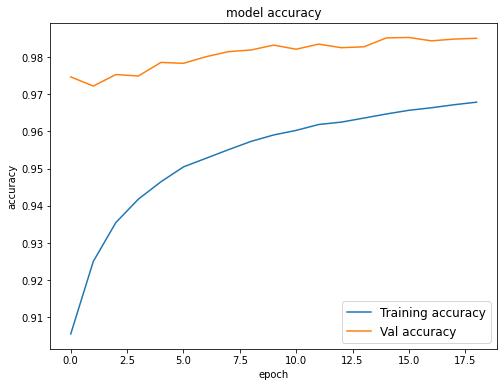

In [36]:
plt.figure(figsize=(8,6))
plt.plot(history.history['Accuracy'], label='Training accuracy')
plt.plot(history.history['val_Accuracy'], label='Val accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(fontsize=12)

plt.savefig(f"steelpan_onset_size-{model_size}_compensate-{compensate}_samplerate-{samplerate}_frame_size-{frame_size}_accuracy.png")

plt.show()

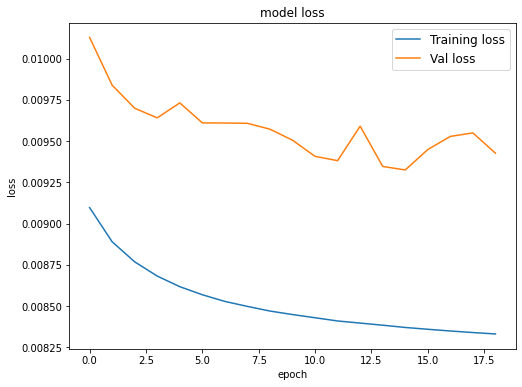

In [37]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(fontsize=12)

plt.savefig(f"steelpan_onset_size-{model_size}_compensate-{compensate}_samplerate-{samplerate}_frame_size-{frame_size}_loss.png")

plt.show()

## Evaluation of the trained model

In [39]:
if train_dataset == 'SASSE_16/train':
  dataset_name = 'SASSE_16/test'
  dataset_path = '/content/SASSE_16/test'
elif train_dataset == 'SASSE_48/train':
  dataset_name = 'SASSE_48/test'
  dataset_path = '/content/SASSE_48/test'
else:
  raise Exception("train_dataset not properly defined")

In [40]:
samplerate = 16000
frame_size = frame_size # this must be 1024 for crepe
eval_step_size = 5
hop_size = int(samplerate * eval_step_size / 1000)
model_capacity = model_size # other options: 'full' 'large' 'medium' 'small' 'tiny'
attack_length = 0.05 # 20 ms

In [41]:
def steelpan_crepe_pred(file_path, model_samplerate, frame_size=1024,
                        step_size=10, onset=True, onset_length=0.05,
                        threshold_pow=1e-06):
  
  audio, _ = librosa.load(file_path, sr=model_samplerate)
  audio = audio.astype(np.float32)

  # Format the audio into frames
  hop_length = int(samplerate * step_size / 1000)
  n_frames = 1 + int((len(audio) - frame_size) / hop_length)
  frames = as_strided(audio, shape=(frame_size, n_frames),
                      strides=(audio.itemsize, hop_length * audio.itemsize))
  frames = frames.transpose().copy()

  # Find the first frame where the levels meet threshold_pow
  for f in range(len(frames)):
    if frame_energy(frames[f]) > threshold_pow:
      start_frame = f
      break
  
  # truncate to onset or when audio dips below threshold
  if onset:
    end_frame = f + int(onset_length * 1000 / step_size)
  else:
    for f in range(len(frames) - 1, -1, -1):
      if frame_energy(frames[f]) > threshold_pow:
        end_frame = f + 1
        break

  frames = frames[start_frame:end_frame]

  # normalize each frame
  frames -= np.mean(frames, axis=1)[:, np.newaxis]
  frames /= np.std(frames, axis=1)[:, np.newaxis]

  # get model activations
  activations = model(frames).numpy()
  cents = []
  
  # prep cents mapping
  # Replaced the number from Crepe because that calibrates predictions to be
  # about 50 cents flat. I wonder if they set their bins up differently than
  # I did...
  cents_mapping = (np.linspace(0, 7180, 360) + 2051.1487628680297) #1997.3794084376191)

  for i in range(activations.shape[0]):
    salience = activations[i, :]

    # convert to local average in cents
    center = int(np.argmax(salience))
    start = max(0, center - 4)
    end = min(len(salience), center + 5)
    salience = salience[start:end]
    product_sum = np.sum(salience * cents_mapping[start:end])
    weight_sum = np.sum(salience)
    ratio = product_sum / weight_sum
    cents.append(ratio)

  cents = np.array(cents)
  frequency = 10 * 2 ** (cents / 1200)
  frequency[np.isnan(frequency)] = 0

  return frequency

In [42]:
model_prediction = steelpan_crepe_pred(
    '/content/SASSE_16/validation/60_valid_sample_1.wav',
    model_samplerate=samplerate, frame_size=frame_size, step_size=10,
    onset=onset)
print(librosa.hz_to_midi(model_prediction))

[60.0366016  60.01421991 60.01457628 60.00369569 59.99988647 59.98664574
 59.97762514 59.9803836  59.98970967 60.00174498 59.99651816 60.00222172
 59.99957891 60.00424809 60.00291028 60.00208049 59.99937578 59.99935277
 59.99996396 60.00181042 60.00728106 60.00479149 60.00541895 60.00329466
 60.00146689 60.00262801 59.99986869 59.99883082 60.00076448 59.99923993
 59.99954391 60.00315514 60.00142241 60.00371171 60.00225521 60.0006054
 60.00383745 59.99764597 60.00120666 59.99583811 59.99465564 59.99361821
 59.99366117 60.00007175 59.99330935 59.99391666 59.9859644  59.98654751
 59.99641068 59.99722239 60.00325223 60.00368091 60.0020186  60.00420725
 60.00207179 60.00234683 60.00177708 60.0005151  60.00282879 59.99955856
 59.99901415 59.9973137  59.99413247 59.99813107 59.9941477  59.99912942
 60.00027706 59.99290234 59.99658225 59.99383334 59.96448    59.96736386
 59.96702872 59.99273732 59.99766181 59.99897793 60.0017155  59.99986671
 60.00104909 59.9991222  60.00222935 60.00503348 60.

In [43]:
def process_folder_model(directory, samplerate, frame_size, 
                         onset=True, onset_length=0.05,
                         step_size=10):
  folder_pitches = []
  folder_targets = []
  file_count = 0
  count = 0

  for (dir_path, _, filenames) in os.walk(directory):
    num_files = len(filenames)
    for filename in filenames:
      file_path = os.path.join(dir_path, filename)

      # in my formatting, the target is given by the first numbers in the filename
      target = float(filename.split("_")[0])
      estimations = steelpan_crepe_pred(file_path, model_samplerate=samplerate,
                                        frame_size=frame_size,
                                        step_size=step_size,
                                        onset=onset,
                                        onset_length=onset_length,
                                        threshold_pow=1e-06)
      
      folder_pitches.append(estimations)
      targets = [target for _ in range(len(estimations))]
      folder_targets.append(targets)

      file_count += 1
      if file_count % 100 == 0:
        print(f'Progress: {file_count}/{num_files}')

  folder_pitches = np.concatenate(folder_pitches)
  folder_targets = np.concatenate(folder_targets)
  print(f"Num files processed: {file_count}")
  return folder_pitches, folder_targets

In [44]:
if samplerate == 16000:
  model_estimates, model_targets = process_folder_model(
      dataset_path,
      samplerate=model_samplerate,
      frame_size=frame_size,
      onset=onset,
      onset_length=attack_length,
      step_size=eval_step_size)
elif samplerate == 48000:
  model_estimates, model_targets = process_folder_model(
      dataset_path,
      samplerate=model_samplerate,
      frame_size=frame_size,
      onset=onset,
      onset_length=attack_length,
      step_size=eval_step_size)

Progress: 100/2702
Progress: 200/2702
Progress: 300/2702
Progress: 400/2702
Progress: 500/2702
Progress: 600/2702
Progress: 700/2702
Progress: 800/2702
Progress: 900/2702
Progress: 1000/2702
Progress: 1100/2702
Progress: 1200/2702
Progress: 1300/2702
Progress: 1400/2702
Progress: 1500/2702
Progress: 1600/2702
Progress: 1700/2702
Progress: 1800/2702
Progress: 1900/2702
Progress: 2000/2702
Progress: 2100/2702
Progress: 2200/2702
Progress: 2300/2702
Progress: 2400/2702
Progress: 2500/2702
Progress: 2600/2702
Progress: 2700/2702
Num files processed: 2702


In [45]:
print(model_estimates.shape, model_targets.shape)

(472608,) (472608,)


### Raw pitch accuracy

In [46]:
model_rpa_50_matches = np.where(np.abs(librosa.hz_to_midi(model_estimates) - model_targets) < 0.5)
model_rpa_25_matches = np.where(np.abs(librosa.hz_to_midi(model_estimates) - model_targets) < 0.25)
model_rpa_10_matches = np.where(np.abs(librosa.hz_to_midi(model_estimates) - model_targets) < 0.1)

In [47]:
model_rpa_50 = model_rpa_50_matches[0].shape[0] / len(model_targets)
print(f"50 cent accuracy: {model_rpa_50}")
model_rpa_25 = model_rpa_25_matches[0].shape[0] / len(model_targets)
print(f"25 cent accuracy: {model_rpa_25}")
model_rpa_10 = model_rpa_10_matches[0].shape[0] / len(model_targets)
print(f"10 cent accuracy: {model_rpa_10}")

50 cent accuracy: 0.9988383607556368
25 cent accuracy: 0.9988023901415126
10 cent accuracy: 0.9835889362854628


In [48]:
model_rpa_50_conf_int = 1.64 * np.sqrt( (model_rpa_50 * (1 - model_rpa_50))  / len(model_targets))
print(f"50 cent rpa std: {model_rpa_50_conf_int}")
model_rpa_25_conf_int = 1.64 * np.sqrt( (model_rpa_25 * (1 - model_rpa_25))  / len(model_targets))
print(f"25 cent rpa std: {model_rpa_25_conf_int}")
model_rpa_10_conf_int = 1.64 * np.sqrt( (model_rpa_10 * (1 - model_rpa_10))  / len(model_targets))
print(f"10 cent rpa std: {model_rpa_10_conf_int}")

50 cent rpa std: 8.125995136870234e-05
25 cent rpa std: 8.250699716726723e-05
10 cent rpa std: 0.0003030878290358746


### Raw chroma accuracy

In [49]:
# offset by -0.5 to account for [11.5,12.5] is the octave error range
model_rca_50_matches = np.where(np.fmod( np.abs(librosa.hz_to_midi(model_estimates) - model_targets + 0.5), 12 ) < 1.0)
model_rca_25_matches = np.where(np.fmod( np.abs(librosa.hz_to_midi(model_estimates) - model_targets + 0.25), 12 ) < 0.5)
model_rca_10_matches = np.where(np.fmod( np.abs(librosa.hz_to_midi(model_estimates) - model_targets + 0.1), 12 ) < 0.2)

In [50]:
model_rca_50 = model_rca_50_matches[0].shape[0] / len(model_targets)
print(f"50 cent accuracy: {model_rca_50}")
model_rca_25 = model_rca_25_matches[0].shape[0] / len(model_targets)
print(f"25 cent accuracy: {model_rca_25}")
model_rca_10 = model_rca_10_matches[0].shape[0] / len(model_targets)
print(f"10 cent accuracy: {model_rca_10}")

50 cent accuracy: 0.9992382693479586
25 cent accuracy: 0.9992022987338344
10 cent accuracy: 0.9925752420610738


In [51]:
model_rca_50_conf_int = 1.64 * np.sqrt( (model_rca_50 * (1 - model_rca_50))  / len(model_targets))
print(f"50 cent rca std: {model_rca_50_conf_int}")
model_rca_25_conf_int = 1.64 * np.sqrt( (model_rca_25 * (1 - model_rca_25))  / len(model_targets))
print(f"25 cent rca std: {model_rca_25_conf_int}")
model_rca_10_conf_int = 1.64 * np.sqrt( (model_rca_10 * (1 - model_rca_10))  / len(model_targets))
print(f"10 cent rca std: {model_rca_10_conf_int}")

50 cent rca std: 6.581555666324999e-05
25 cent rca std: 6.735039801559327e-05
10 cent rca std: 0.0002047935066883152


## Collate data

In [ ]:
if onset:
  model_data = {
      'train_dataset': [train_dataset],
      'model_capacity': [model_capacity],
      'train_step_size': [train_step_size],
      'compensate': [compensate],
      'model_samplerate': [model_samplerate],
      'eval_dataset': [dataset_name],
      'frame_length': [frame_size],
      'eval_step_size': [eval_step_size],
      'smp_length': [attack_length],
      'frames_analyzed': [model_estimates.shape[0]],
      'rpa50': [model_rpa_50],
      'rpa50_std': [model_rpa_50_conf_int],
      'rpa25': [model_rpa_25],
      'rpa25_std': [model_rpa_25_conf_int],
      'rpa10': [model_rpa_10],
      'rpa10_std': [model_rpa_10_conf_int],
      'rca50': [model_rca_50],
      'rca50_std': [model_rca_50_conf_int],
      'rca25': [model_rca_25],
      'rca25_std': [model_rca_25_conf_int],
      'rca10': [model_rca_10],
      'rca10_std': [model_rca_10_conf_int],
  }
else:
  model_data = {
      'train_dataset': [train_dataset],
      'model_capacity': [model_capacity],
      'train_step_size': [train_step_size],
      'compensate': [compensate],
      'model_samplerate': [model_samplerate],
      'eval_dataset': [dataset_name],
      'frame_length': [frame_size],
      'eval_step_size': [eval_step_size],
      'smp_length': ['full'],
      'frames_analyzed': [model_estimates.shape[0]],
      'rpa50': [model_rpa_50],
      'rpa50_std': [model_rpa_50_conf_int],
      'rpa25': [model_rpa_25],
      'rpa25_std': [model_rpa_25_conf_int],
      'rpa10': [model_rpa_10],
      'rpa10_std': [model_rpa_10_conf_int],
      'rca50': [model_rca_50],
      'rca50_std': [model_rca_50_conf_int],
      'rca25': [model_rca_25],
      'rca25_std': [model_rca_25_conf_int],
      'rca10': [model_rca_10],
      'rca10_std': [model_rca_10_conf_int],
  }

In [ ]:
model_data

{'train_dataset': ['SASSE_16/train'],
 'model_capacity': ['medium'],
 'train_step_size': [4],
 'compensate': [False],
 'model_samplerate': [16000],
 'eval_dataset': ['SASSE_16/test'],
 'frame_length': [128],
 'eval_step_size': [5],
 'smp_length': ['full'],
 'frames_analyzed': [489741],
 'rpa50': [0.981792416808068],
 'rpa50_std': [0.0003133261226075393],
 'rpa25': [0.976130240269857],
 'rpa25_std': [0.0003577161299749535],
 'rpa10': [0.9487953836823954],
 'rpa10_std': [0.0005165370237474396],
 'rca50': [0.992222419605465],
 'rca50_std': [0.00020586730944998738],
 'rca25': [0.988079413404228],
 'rca25_std': [0.0002543345466876934],
 'rca10': [0.9703578013684785],
 'rca10_std': [0.0003974493340898432]}

In [ ]:
model_eval_df = pd.DataFrame.from_dict(model_data)

In [ ]:
model_eval_df.head()

,train_dataset,model_capacity,train_step_size,compensate,model_samplerate,eval_dataset,frame_length,eval_step_size,smp_length,frames_analyzed,...,rpa25,rpa25_std,rpa10,rpa10_std,rca50,rca50_std,rca25,rca25_std,rca10,rca10_std
0,SASSE_16/train,medium,4,False,16000,SASSE_16/test,128,5,full,489741,...,0.97613,0.000358,0.948795,0.000517,0.992222,0.000206,0.988079,0.000254,0.970358,0.000397


### Save to dataframe

**TODO:**
- Set this up to load the model eval csv from Github
- Append new data and then output a new csv file for upload to Github

In [ ]:
model_eval_df.to_csv('steelpan_pitch_onset_model_eval.csv')

In [ ]:
pd.DataFrame.from_dict(model.history.history).to_csv(
    f'steelpan_onset_size-{model_size}_compensate-{compensate}_samplerate-{samplerate}_frame_size-{frame_size}_history.csv', index=False)

# Generalization

This section is to show that Steelpan-Pitch generalizes to othe steelpan audio.

In [ ]:
sr = 16000
narell_audio, _ = librosa.load('/content/Andy Narell Tenor Pan 5.wav', sr=sr)

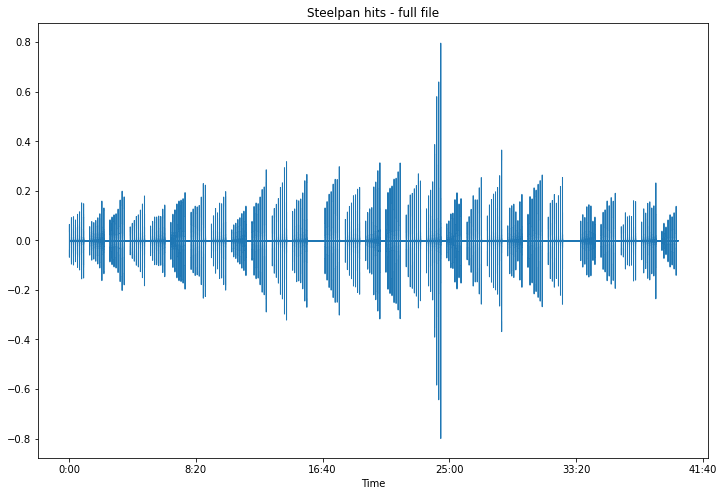

In [ ]:
# plot the audio file
fig, ax = plt.subplots(figsize=(12,8))
display.waveshow(narell_audio, sr=sr, ax=ax)
ax.set(title='Steelpan hits - full file')

plt.show()

In [ ]:
non_mute_sections = librosa.effects.split(narell_audio, top_db=30,
                                          frame_length=4096,
                                          hop_length=1024)

In [ ]:
print(len(non_mute_sections))

232


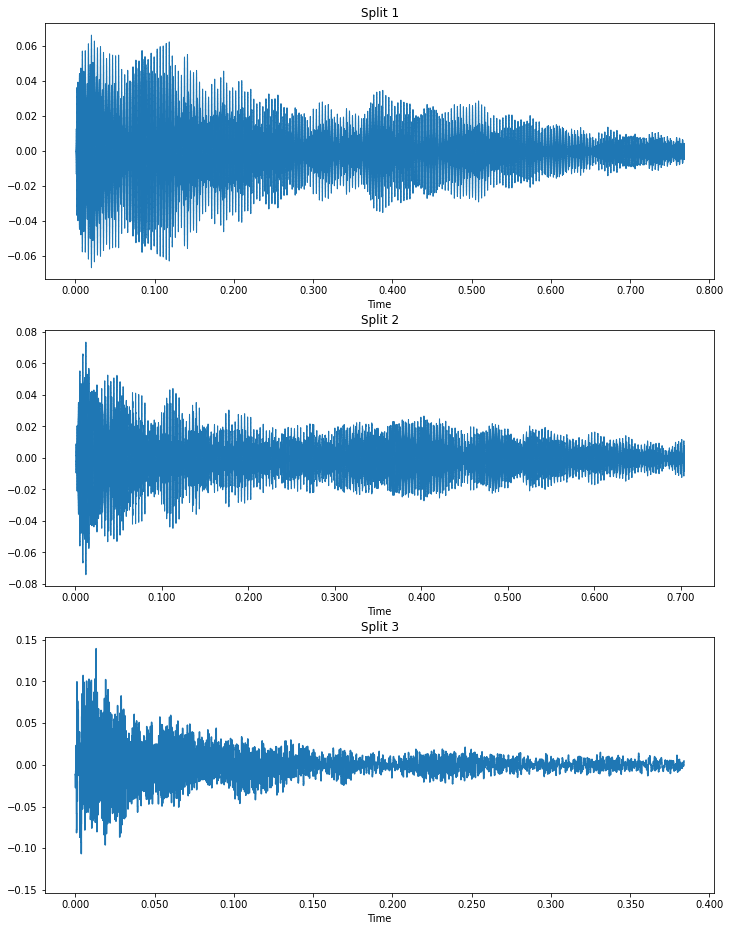

In [ ]:
rand_i = np.random.randint(232, size=3)
r1 = rand_i[0]
r2 = rand_i[1]
r3 = rand_i[2]

split_1, _ = librosa.effects.trim(
    narell_audio[non_mute_sections[0][0]:non_mute_sections[0][1]],
    top_db=24,
    frame_length=128,
    hop_length=64
    )
split_2, _ = librosa.effects.trim(
    narell_audio[non_mute_sections[10][0]:non_mute_sections[10][1]],
    top_db=24,
    frame_length=128,
    hop_length=64
    )
split_3, _ = librosa.effects.trim(
    narell_audio[non_mute_sections[231][0]:non_mute_sections[231][1]],
    top_db=24,
    frame_length=128,
    hop_length=64
    )

# plot a few of the hits
fig, ax = plt.subplots(nrows=3, figsize=(12,16))
display.waveshow(split_1, sr=sr, ax=ax[0])
ax[0].set(title='Split 1')

display.waveshow(split_2, sr=sr, ax=ax[1])
ax[1].set(title='Split 2')

display.waveshow(split_3, sr=sr, ax=ax[2])
ax[2].set(title='Split 3')

plt.show()

## Evaluation

We have now isolated the non-mute sections of the audio file and trimmed leading and trailing silence from each section. We can now apply this to the entire file to generate our generalization dataset.

In [ ]:
def steelpan_crepe_pred_audio(audio, model_samplerate, frame_size=1024,
                        step_size=10, onset=True, onset_length=0.05,
                        threshold_pow=1e-06):
  
  audio = audio.astype(np.float32)

  # Format the audio into frames
  hop_length = int(samplerate * step_size / 1000)
  n_frames = 1 + int((len(audio) - frame_size) / hop_length)
  frames = as_strided(audio, shape=(frame_size, n_frames),
                      strides=(audio.itemsize, hop_length * audio.itemsize))
  frames = frames.transpose().copy()

  # Find the first frame where the levels meet threshold_pow
  for f in range(len(frames)):
    if frame_energy(frames[f]) > threshold_pow:
      start_frame = f
      break
  
  # truncate to onset or when audio dips below threshold
  if onset:
    end_frame = f + int(onset_length * 1000 / step_size)
  else:
    for f in range(len(frames) - 1, -1, -1):
      if frame_energy(frames[f]) > threshold_pow:
        end_frame = f + 1
        break

  frames = frames[start_frame:end_frame]

  # normalize each frame
  frames -= np.mean(frames, axis=1)[:, np.newaxis]
  frames /= np.std(frames, axis=1)[:, np.newaxis]

  # get model activations
  activations = model(frames).numpy()
  cents = []
  
  # prep cents mapping
  # Replaced the number from Crepe because that calibrates predictions to be
  # about 50 cents flat. I wonder if they set their bins up differently than
  # I did...
  cents_mapping = (np.linspace(0, 7180, 360) + 2051.1487628680297) #1997.3794084376191)

  for i in range(activations.shape[0]):
    salience = activations[i, :]

    # convert to local average in cents
    center = int(np.argmax(salience))
    start = max(0, center - 4)
    end = min(len(salience), center + 5)
    salience = salience[start:end]
    product_sum = np.sum(salience * cents_mapping[start:end])
    weight_sum = np.sum(salience)
    ratio = product_sum / weight_sum
    cents.append(ratio)

  cents = np.array(cents)
  frequency = 10 * 2 ** (cents / 1200)
  frequency[np.isnan(frequency)] = 0

  return frequency

In [ ]:
def split_andy_narell_dataset(x, splits, samplerate=16000, step_size=10,
                              onset=False, onset_length=0.05):
  
  # organize by target

  full_estimations = []
  full_targets = []

  split_count = 0

  for idx in range(len(splits)):
    # split audio
    split_audio = x[splits[idx][0]:splits[idx][1]]
    # trim silence
    split_audio, _ = librosa.effects.trim(split_audio, top_db=24,
                                          frame_length=128, hop_length=64)
    
    # calculate target
    target = (idx // 8) + 60 # 8 hits per note, starting at midi note 60, moving upwards chromatically

    # get predictions for audio split
    split_estimations =steelpan_crepe_pred_audio(split_audio,
                                                 model_samplerate=samplerate,
                                                 frame_size=frame_size,
                                                 step_size=step_size,
                                                 onset=onset,
                                                 onset_length=onset_length,
                                                 threshold_pow=1e-06)
    
    full_estimations.append(split_estimations)
    targets = [target for _ in range(len(split_estimations))]
    full_targets.append(targets)

    split_count += 1
    if split_count % 25 == 0:
      print(f'Progress: {split_count}/{len(splits)} processed')

  full_estimations = np.concatenate(full_estimations)
  full_targets = np.concatenate(full_targets)
  print(f'Progress: {split_count}/{len(splits)}')

  return full_estimations, full_targets

### Raw pitch accuracy

In [ ]:
est, targets = split_andy_narell_dataset(narell_audio, non_mute_sections)

Progress: 25/232 processed
Progress: 50/232 processed
Progress: 75/232 processed
Progress: 100/232 processed
Progress: 125/232 processed
Progress: 150/232 processed
Progress: 175/232 processed
Progress: 200/232 processed
Progress: 225/232 processed
Progress: 232/232


In [ ]:
print(est.shape)
print(targets.shape)

(14294,)
(14294,)


In [ ]:
i = 250

print(np.round(librosa.hz_to_midi(est[i*48:(i+1)*48]),2))
print(targets[i*48:(i+1)*48])

[69.01 68.97 69.   69.   68.99 81.24 81.02 81.01 81.01 81.01 81.   81.01
 81.01 81.01 81.01 81.01 81.01 81.02 81.04 69.01 68.99 68.98 81.01 81.01
 81.01 68.97 81.   81.01 68.99 81.01 68.99 68.99 69.   68.98 68.98 69.
 81.01 69.03 81.05 69.01 69.   81.02 81.02 81.02 68.99 81.01 81.02 81.  ]
[81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81
 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81]


In [ ]:
narell_rpa_50_matches = np.where(np.abs(librosa.hz_to_midi(est) - targets) < 0.5)
narell_rpa_25_matches = np.where(np.abs(librosa.hz_to_midi(est) - targets) < 0.25)
narell_rpa_10_matches = np.where(np.abs(librosa.hz_to_midi(est) - targets) < 0.1)

In [ ]:
narell_rpa_50 = narell_rpa_50_matches[0].shape[0] / len(targets)
print(f"50 cent accuracy: {narell_rpa_50}")
narell_rpa_25 = narell_rpa_25_matches[0].shape[0] / len(targets)
print(f"25 cent accuracy: {narell_rpa_25}")
narell_rpa_10 = narell_rpa_10_matches[0].shape[0] / len(targets)
print(f"10 cent accuracy: {narell_rpa_10}")

50 cent accuracy: 0.8532251294249336
25 cent accuracy: 0.8221631453756821
10 cent accuracy: 0.7314957324751644


File 1: in the 70s

File 2: 87.9

File 3: 82

File 4: 85

File 5: 84

In [ ]:
narell_rpa_50_conf_int = 1.64 * np.sqrt( (narell_rpa_50 * (1 - narell_rpa_50))  / len(targets))
print(f"50 cent rpa std: {narell_rpa_50_conf_int}")
narell_rpa_25_conf_int = 1.64 * np.sqrt( (narell_rpa_25 * (1 - narell_rpa_25))  / len(targets))
print(f"25 cent rpa std: {narell_rpa_25_conf_int}")
narell_rpa_10_conf_int = 1.64 * np.sqrt( (narell_rpa_10 * (1 - narell_rpa_10))  / len(targets))
print(f"10 cent rpa std: {narell_rpa_10_conf_int}")

50 cent rpa std: 0.004854277852737916
25 cent rpa std: 0.00524513711711543
10 cent rpa std: 0.006079228309142034


### Raw chorma accuracy



In [ ]:
# offset by -0.5 to account for [11.5,12.5] is the octave error range
narell_rca_50_matches = np.where(np.fmod( np.abs(librosa.hz_to_midi(est) - targets + 0.5), 12 ) < 1.0)
narell_rca_25_matches = np.where(np.fmod( np.abs(librosa.hz_to_midi(est) - targets + 0.25), 12 ) < 0.5)
narell_rca_10_matches = np.where(np.fmod( np.abs(librosa.hz_to_midi(est) - targets + 0.1), 12 ) < 0.2)

In [ ]:
narell_rca_50 = narell_rca_50_matches[0].shape[0] / len(targets)
print(f"50 cent accuracy: {narell_rca_50}")
narell_rca_25 = narell_rca_25_matches[0].shape[0] / len(targets)
print(f"25 cent accuracy: {narell_rca_25}")
narell_rca_10 = narell_rca_10_matches[0].shape[0] / len(targets)
print(f"10 cent accuracy: {narell_rca_10}")

50 cent accuracy: 0.9543164964320694
25 cent accuracy: 0.9350076955365888
10 cent accuracy: 0.8829578844270323


In [ ]:
narell_rca_50_conf_int = 1.64 * np.sqrt( (narell_rca_50 * (1 - narell_rca_50))  / len(targets))
print(f"50 cent rpa std: {narell_rca_50_conf_int}")
narell_rca_25_conf_int = 1.64 * np.sqrt( (narell_rca_25 * (1 - narell_rca_25))  / len(targets))
print(f"25 cent rpa std: {narell_rca_25_conf_int}")
narell_rca_10_conf_int = 1.64 * np.sqrt( (narell_rca_10 * (1 - narell_rca_10))  / len(targets))
print(f"10 cent rpa std: {narell_rca_10_conf_int}")

50 cent rpa std: 0.002864130990712548
25 cent rpa std: 0.0033814698534157753
10 cent rpa std: 0.004409689751151081
